# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.88'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--008--Spec.Data 1.txt',
 '02 Ne--Spectrum--009--Spec.Data 1.txt',
 '03 Ne--Spectrum--010--Spec.Data 1.txt',
 '04 Ne--Spectrum--011--Spec.Data 1.txt',
 '11 Ne--Spectrum--019--Spec.Data 1.txt',
 '15 Ne--Spectrum--031--Spec.Data 1.txt',
 '20 Ne--Spectrum--037--Spec.Data 1.txt',
 '27 Ne--Spectrum--060--Spec.Data 1.txt',
 '31 Ne--Spectrum--078--Spec.Data 1.txt',
 '36 Ne--Spectrum--093--Spec.Data 1.txt',
 '40 Ne--Spectrum--104--Spec.Data 1.txt',
 '47 Ne--Spectrum--122--Spec.Data 1.txt',
 '54 Ne--Spectrum--137--Spec.Data 1.txt',
 '55 Ne--Spectrum--138--Spec.Data 1.txt',
 '56 Ne--Spectrum--139--Spec.Data 1.txt',
 '57 Ne--Spectrum--140--Spec.Data 1.txt',
 '59 Ne--Spectrum--142--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--008--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583        4911.0  1447.663174   44950.66797  4193.900018   

     Peak2_prom  
0  44233.567988

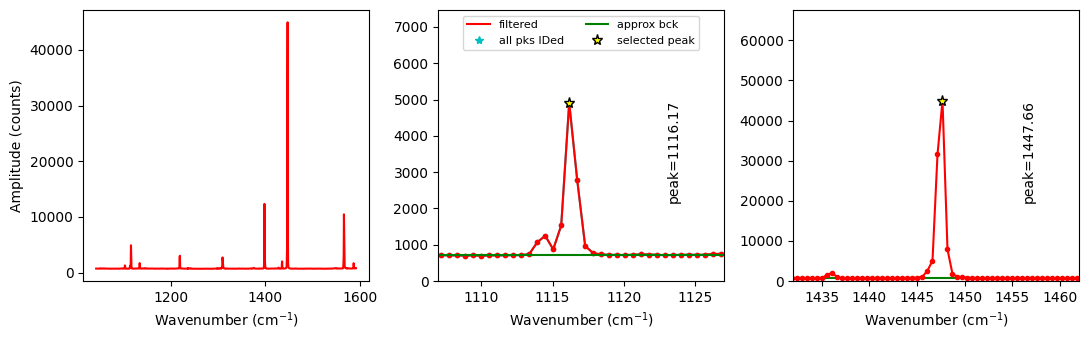

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--008--Spec.Data 1.txt         0.000043    0.000043   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0     1447.47529   50056.559934   0.387593      None   0.001851   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe   Ne_Corr  \
0        0.403089    1116.287474  ...        0.335794  331.187816  0.997856   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997808     0.997904    116.215631     12.470522        128.686153   

   error_pk1_amplitude  error_pk2_amplitude  
0           202.293615           355.663863  

[1 rows x 24 columns]

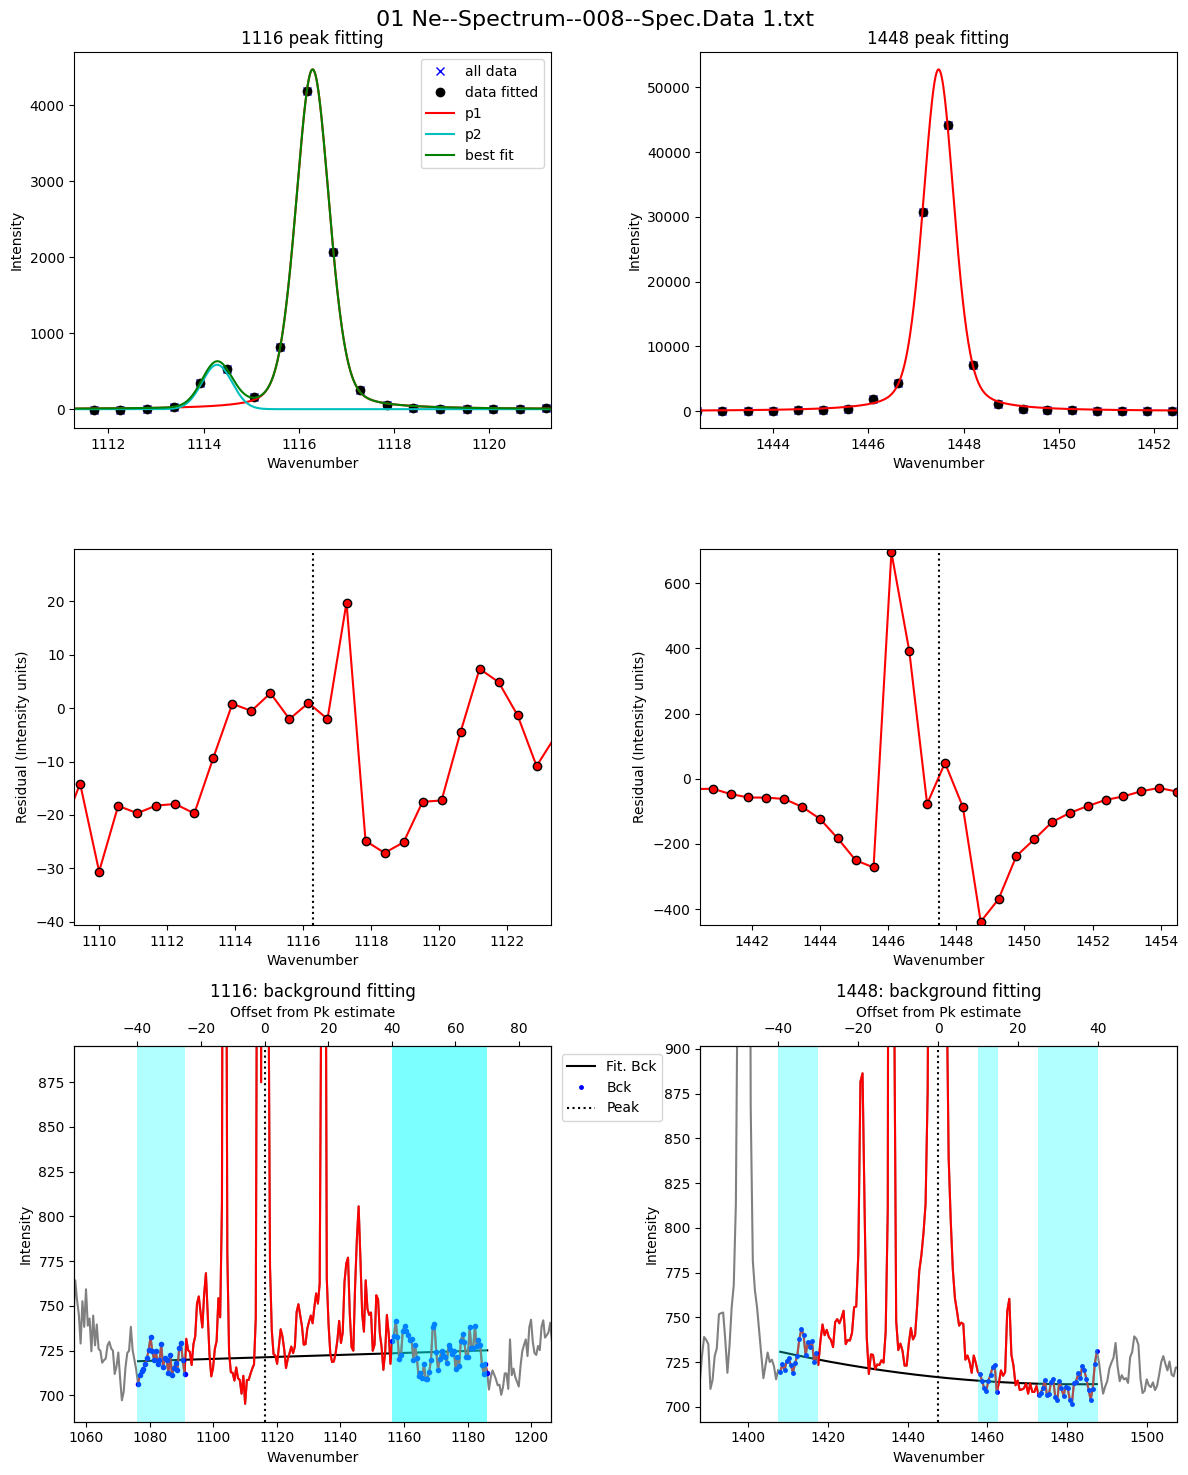

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/17 [00:00<?, ?it/s]

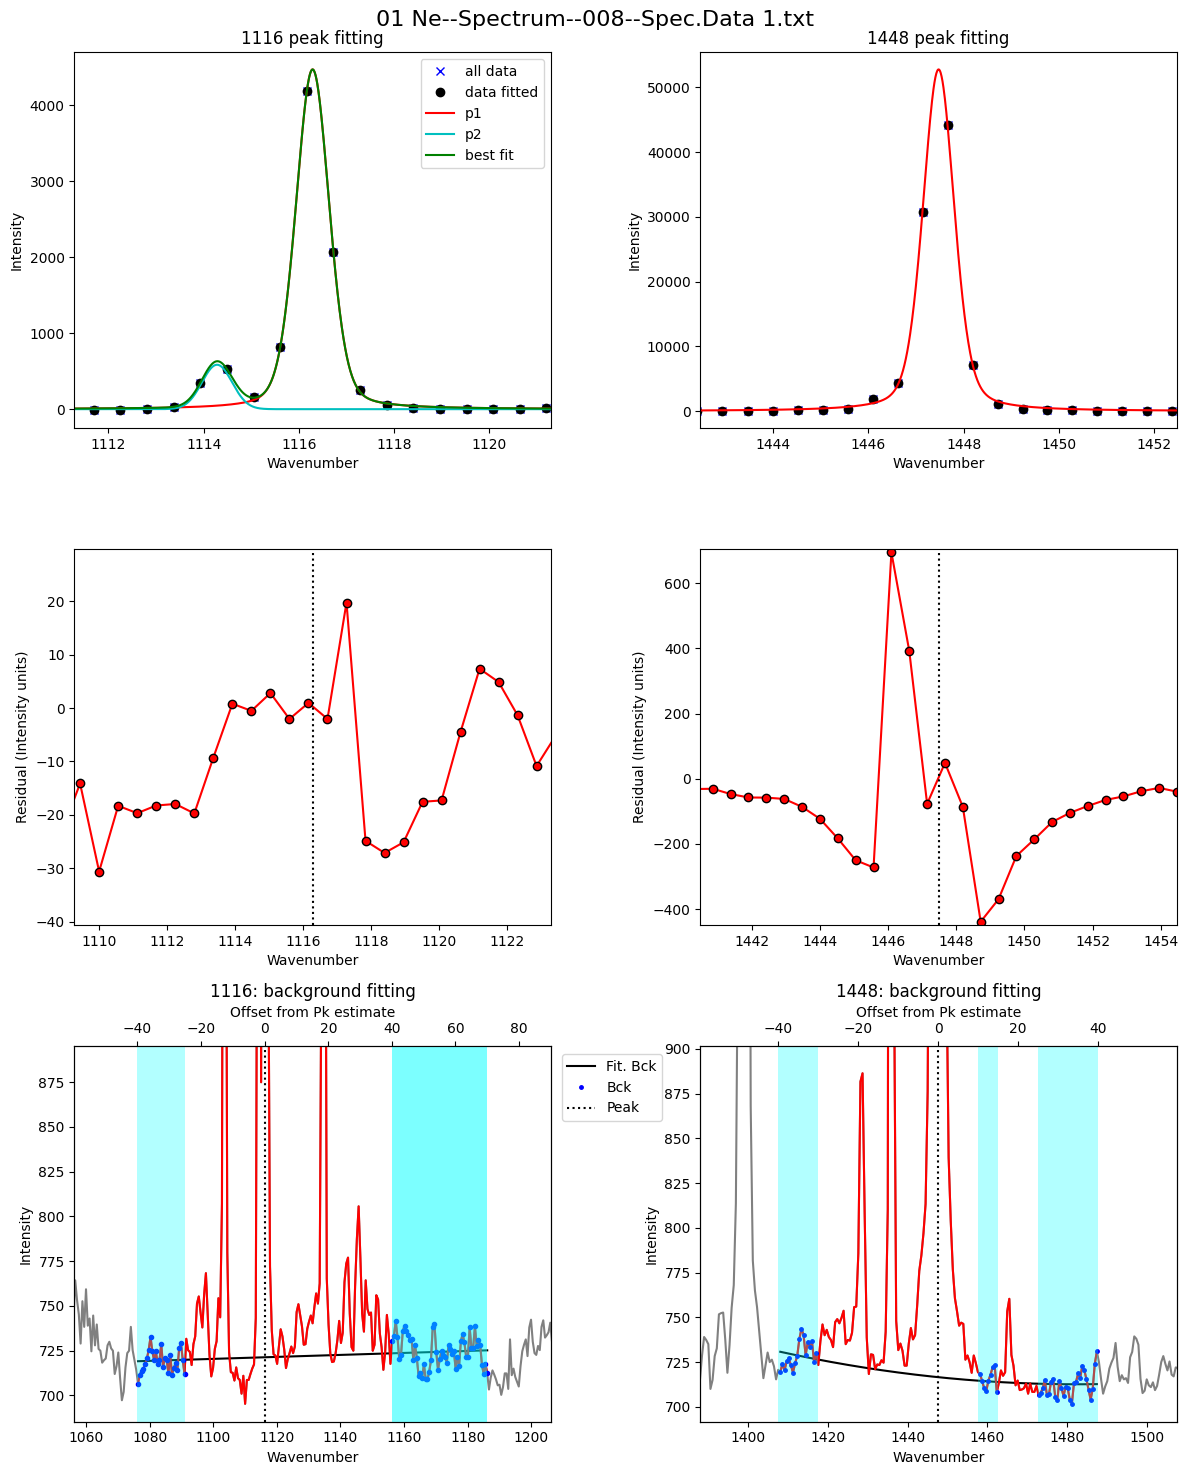

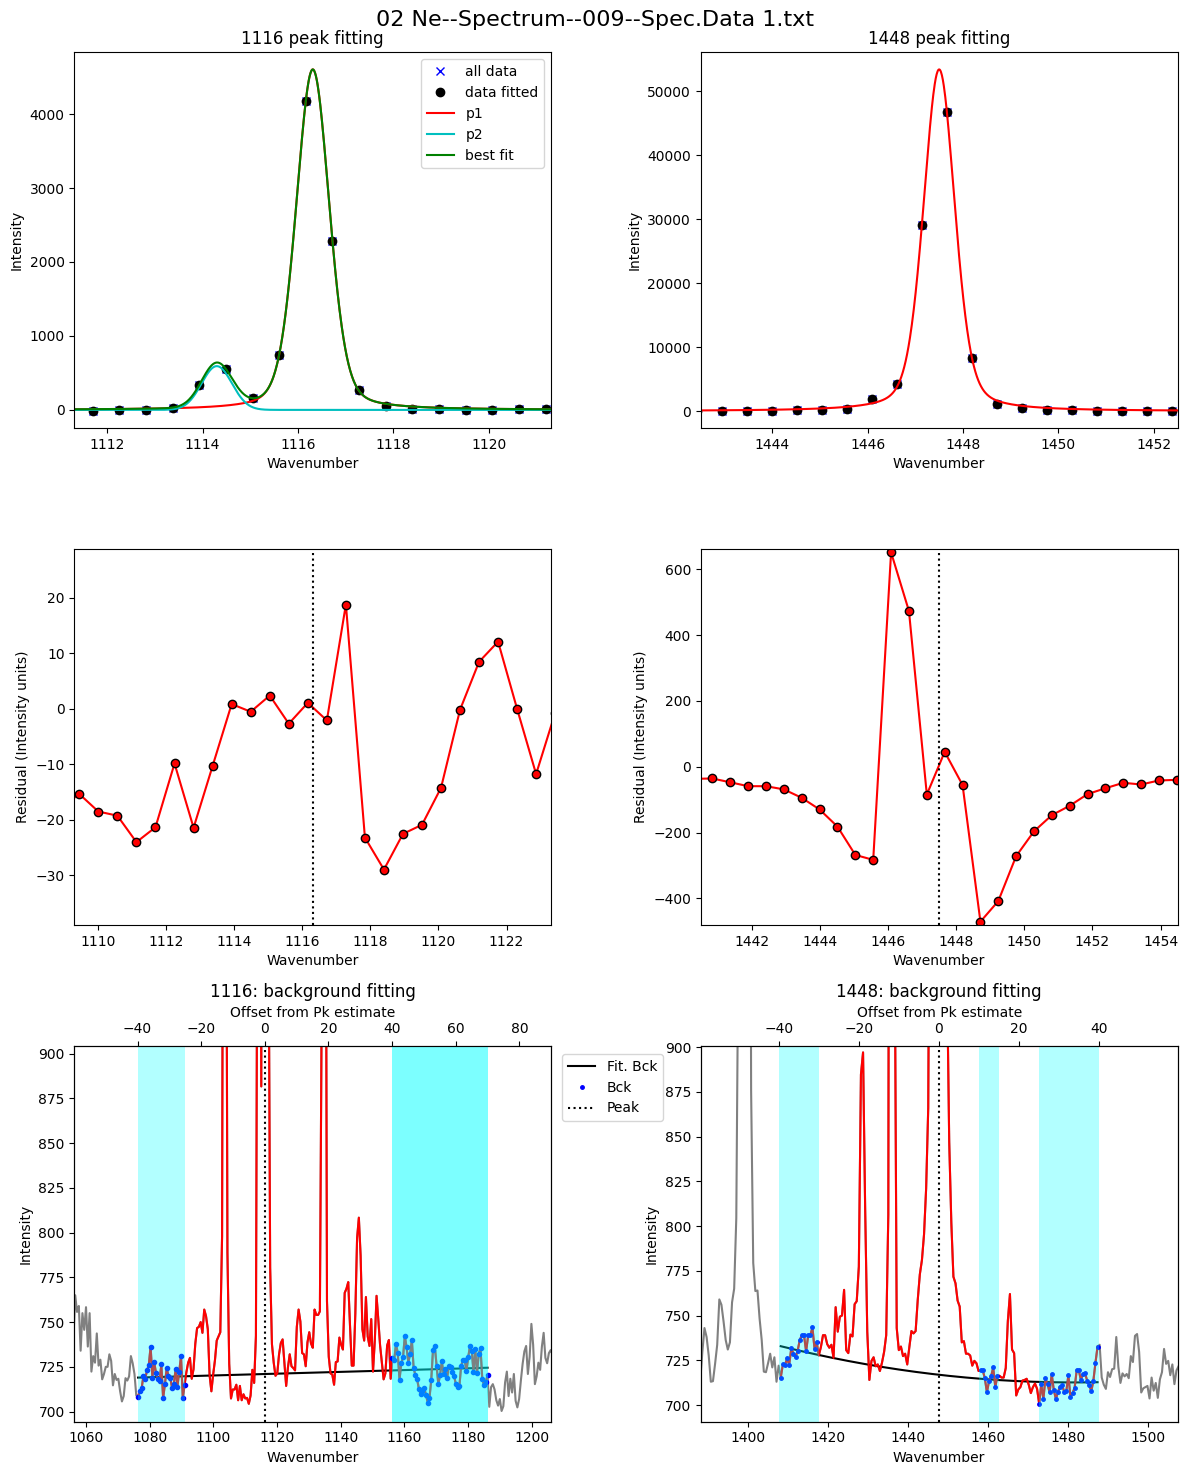

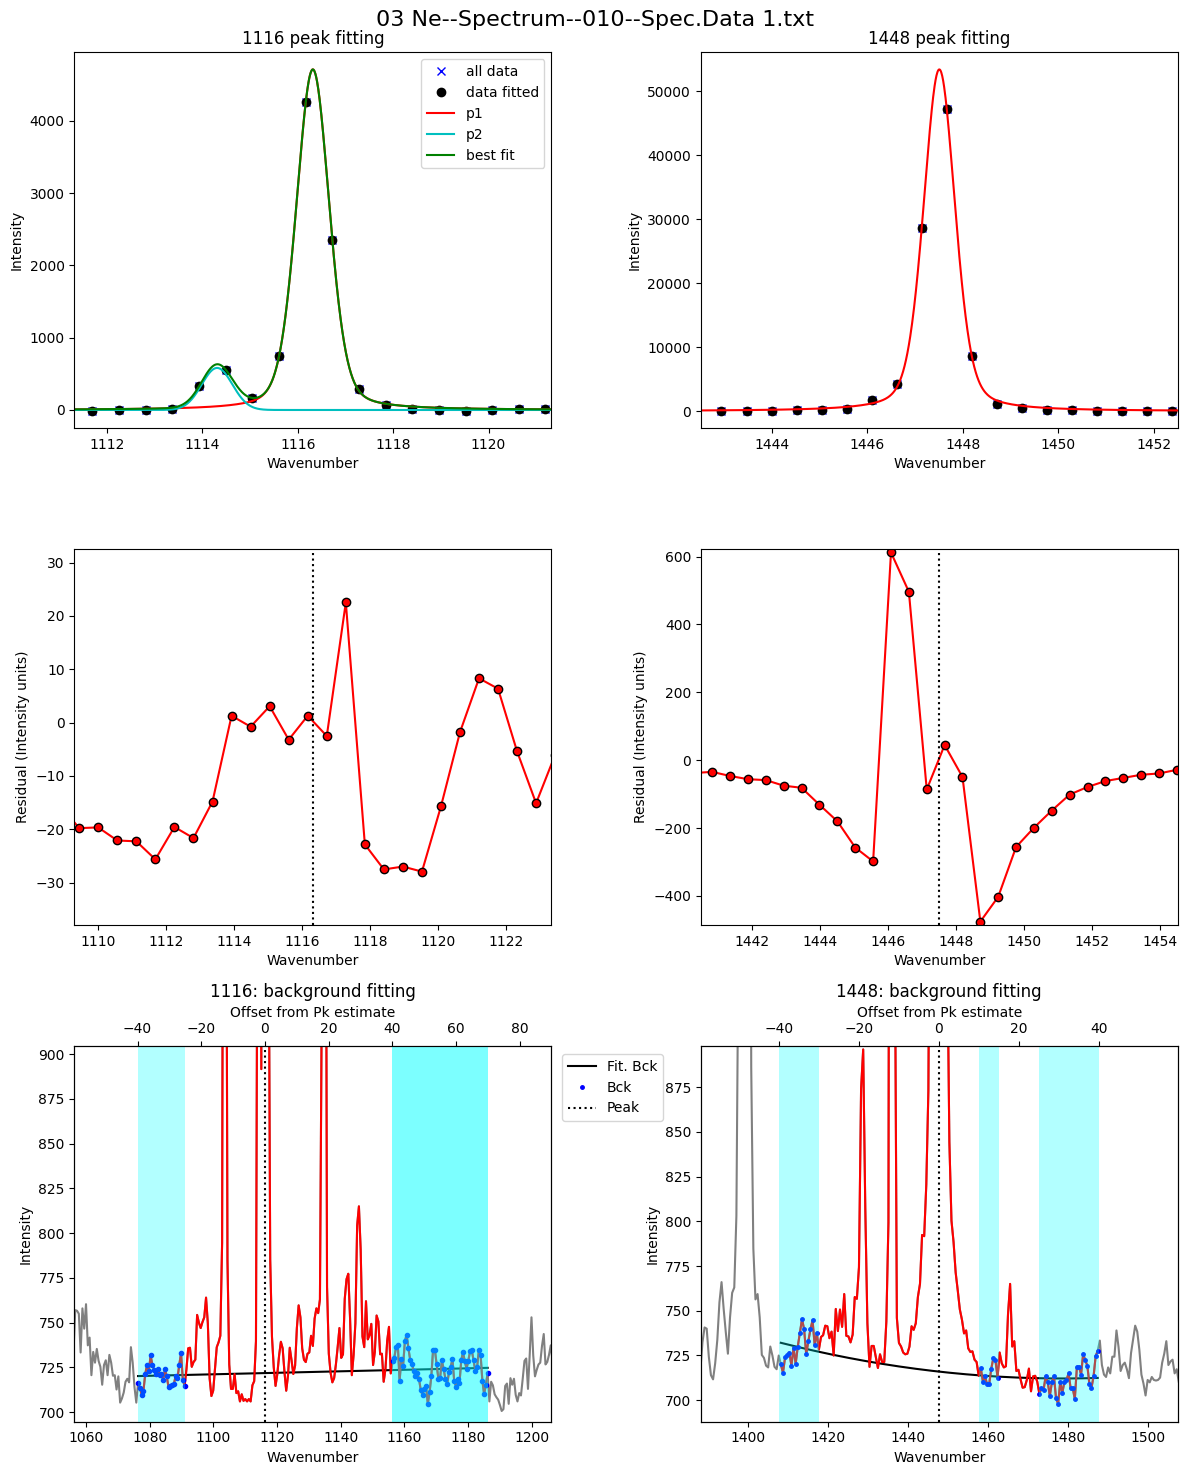

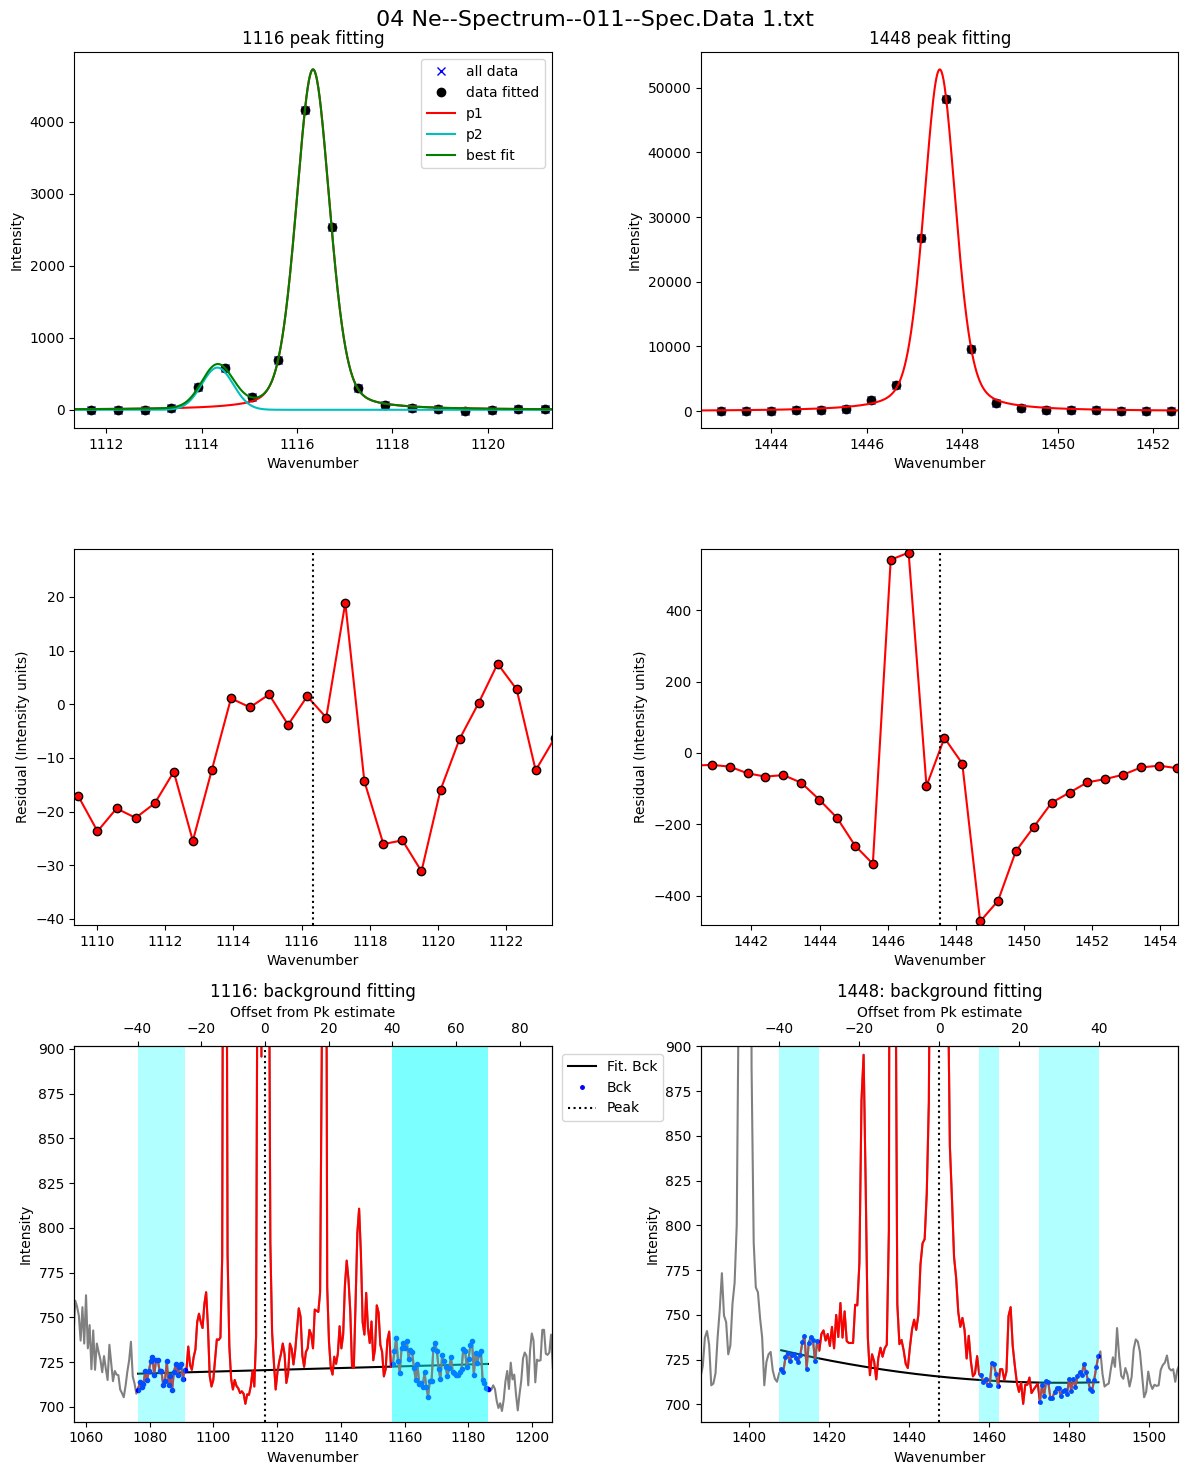

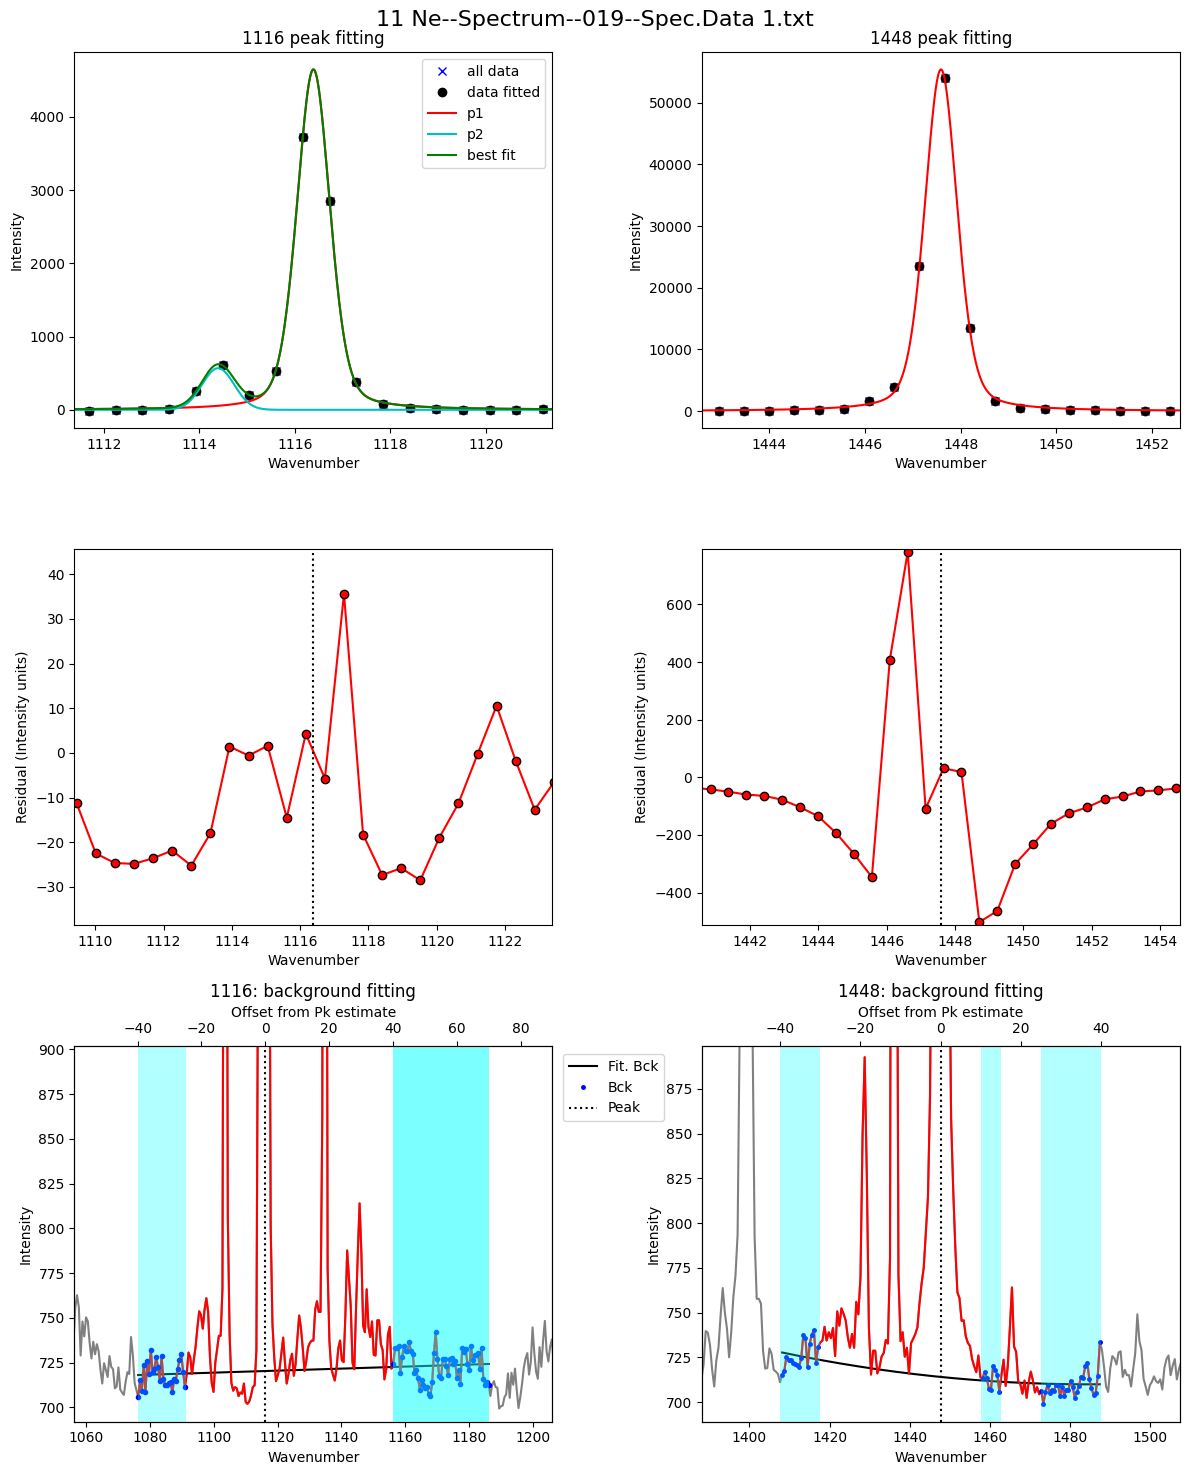

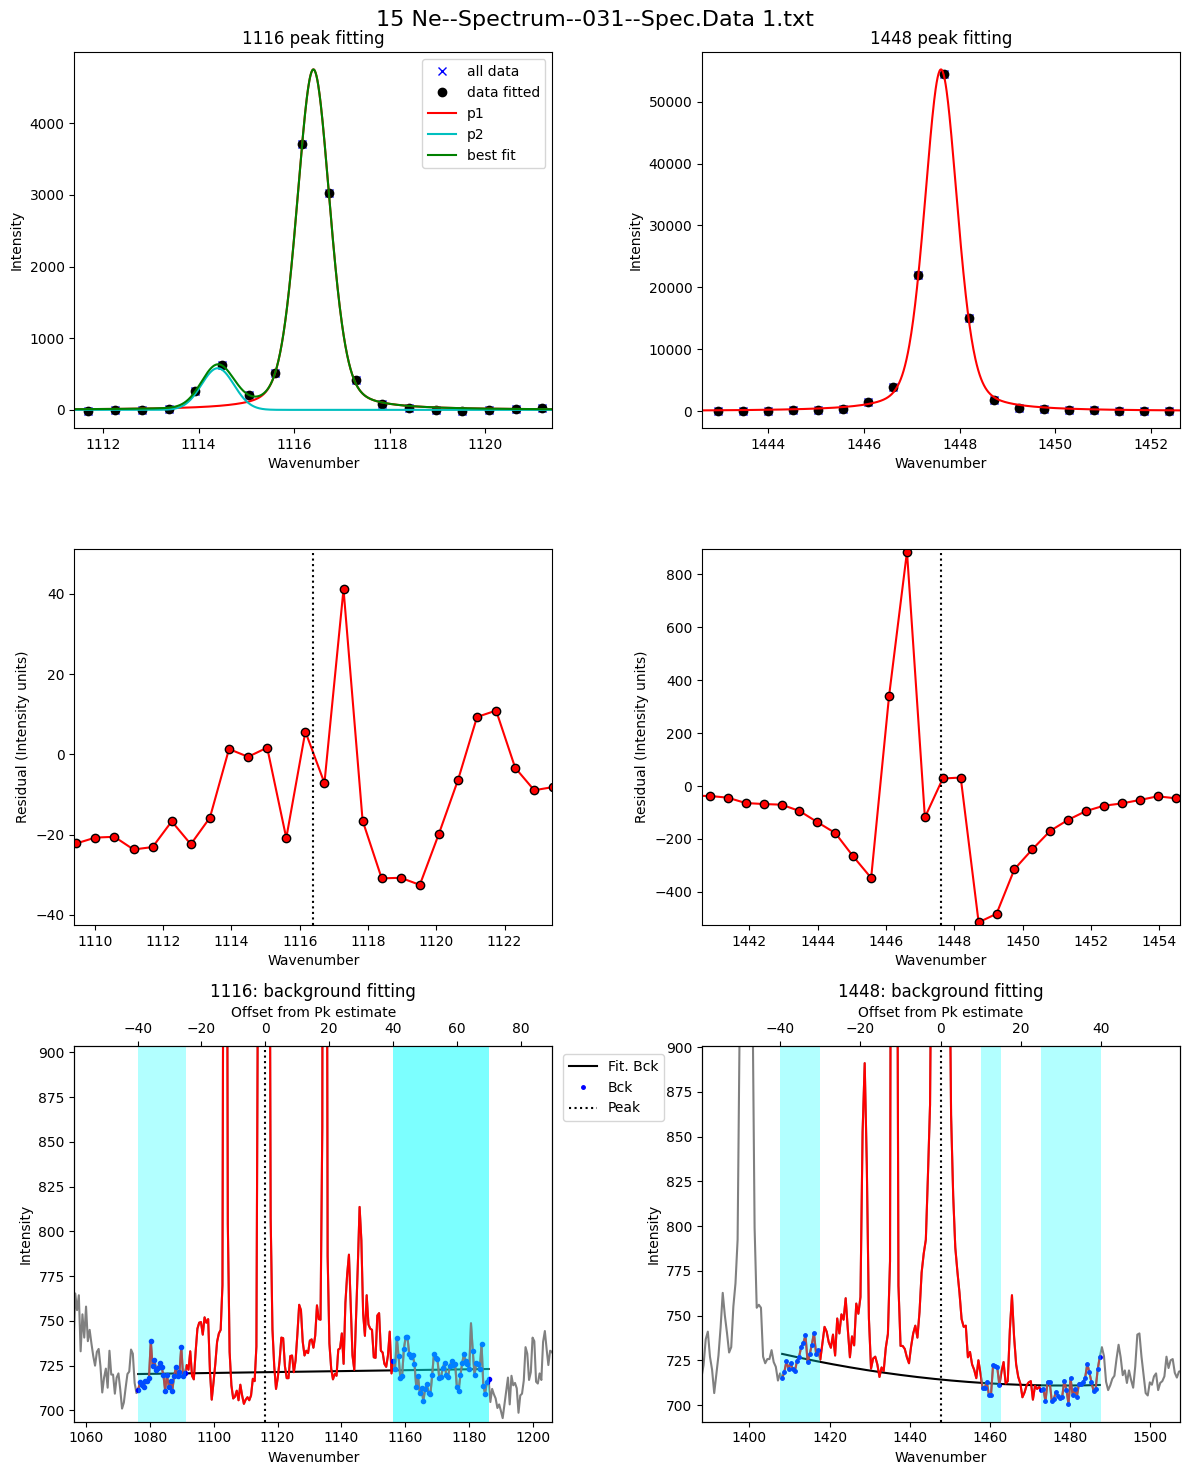

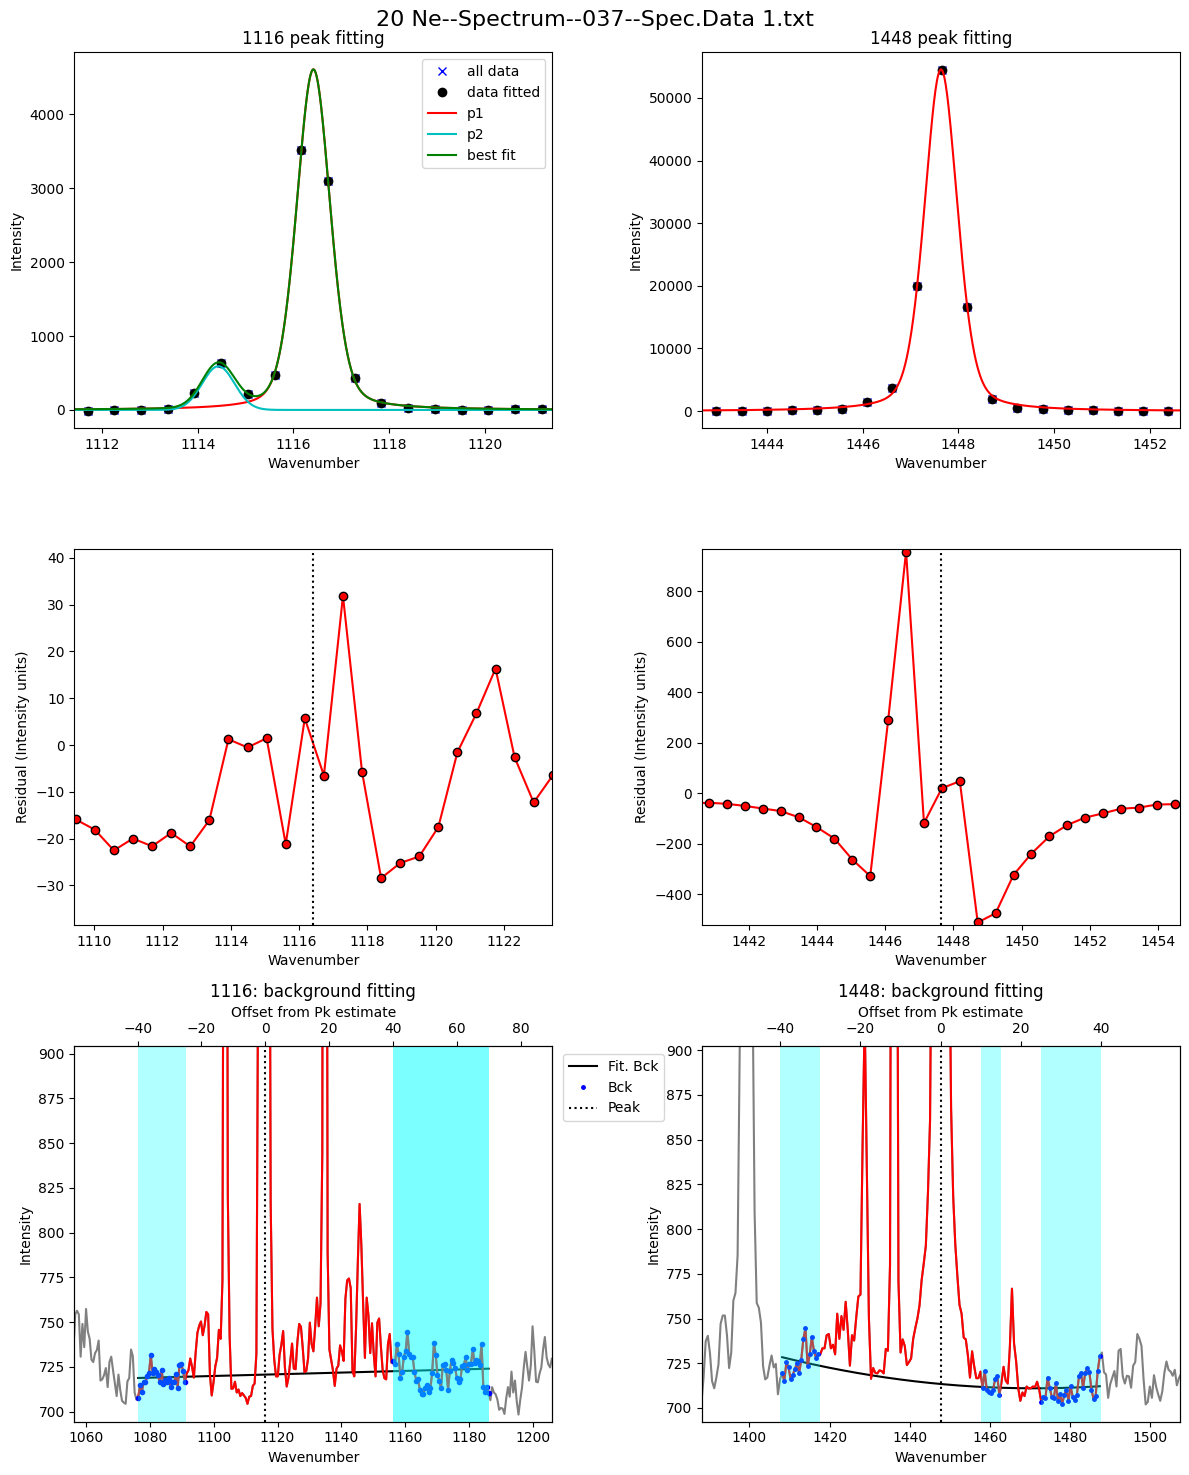

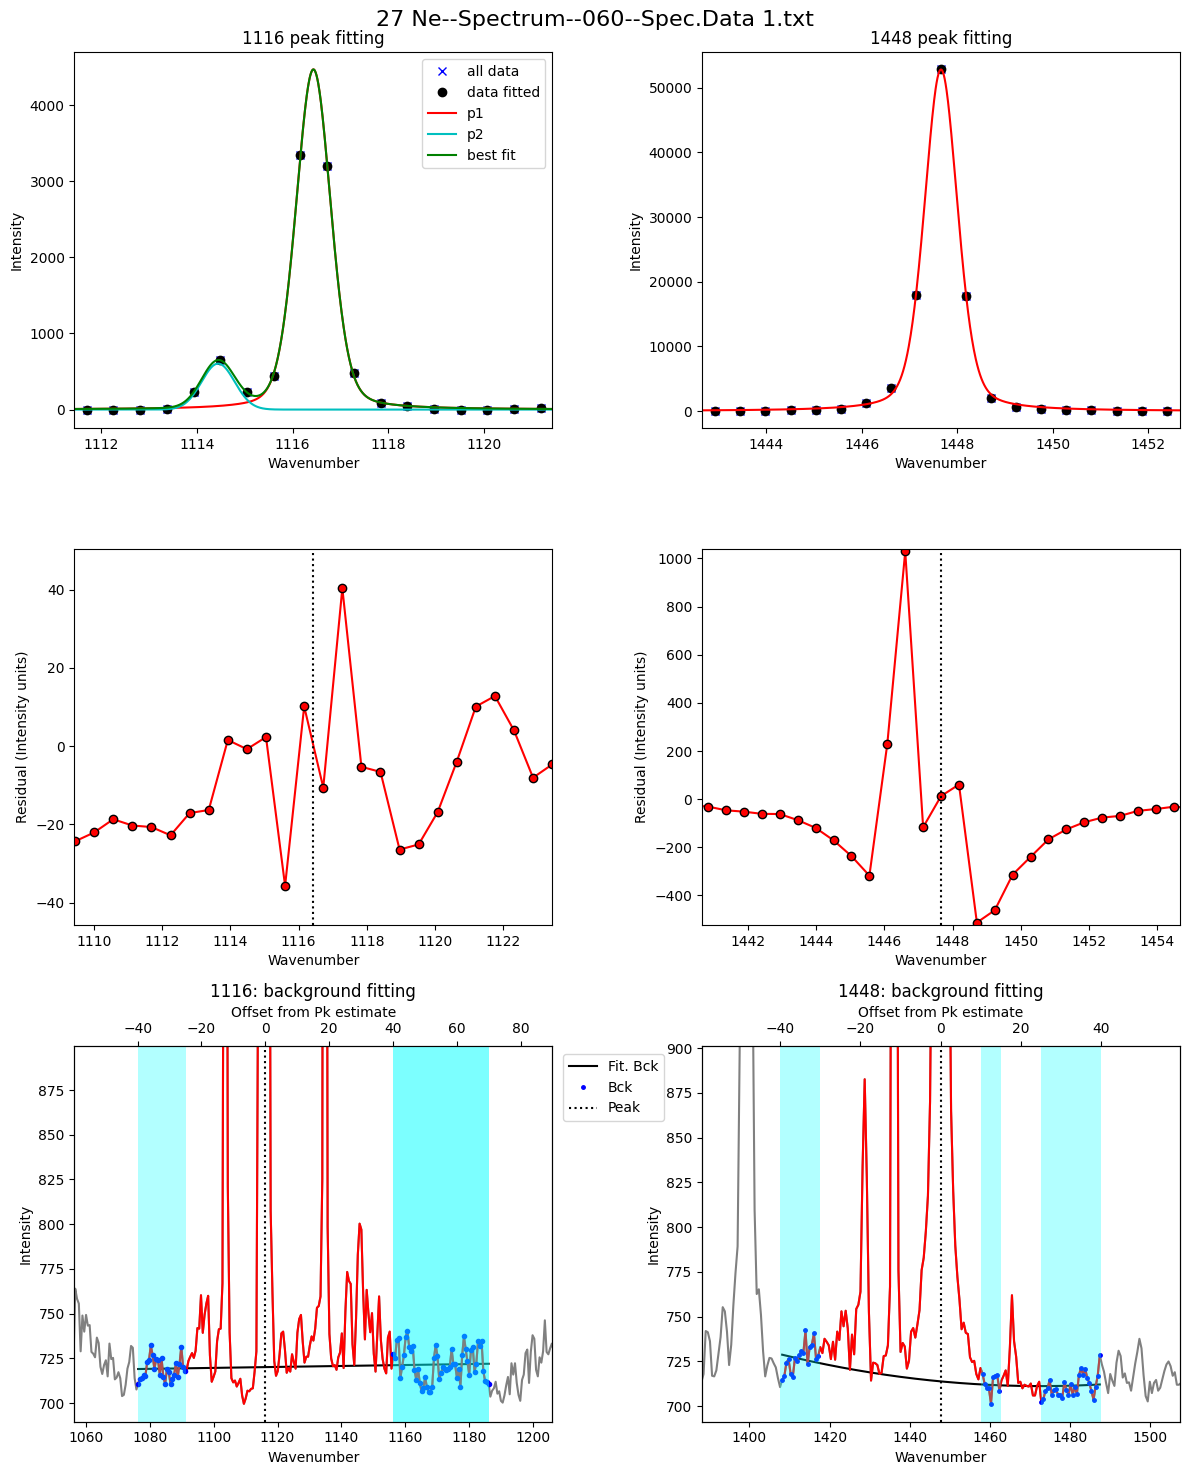

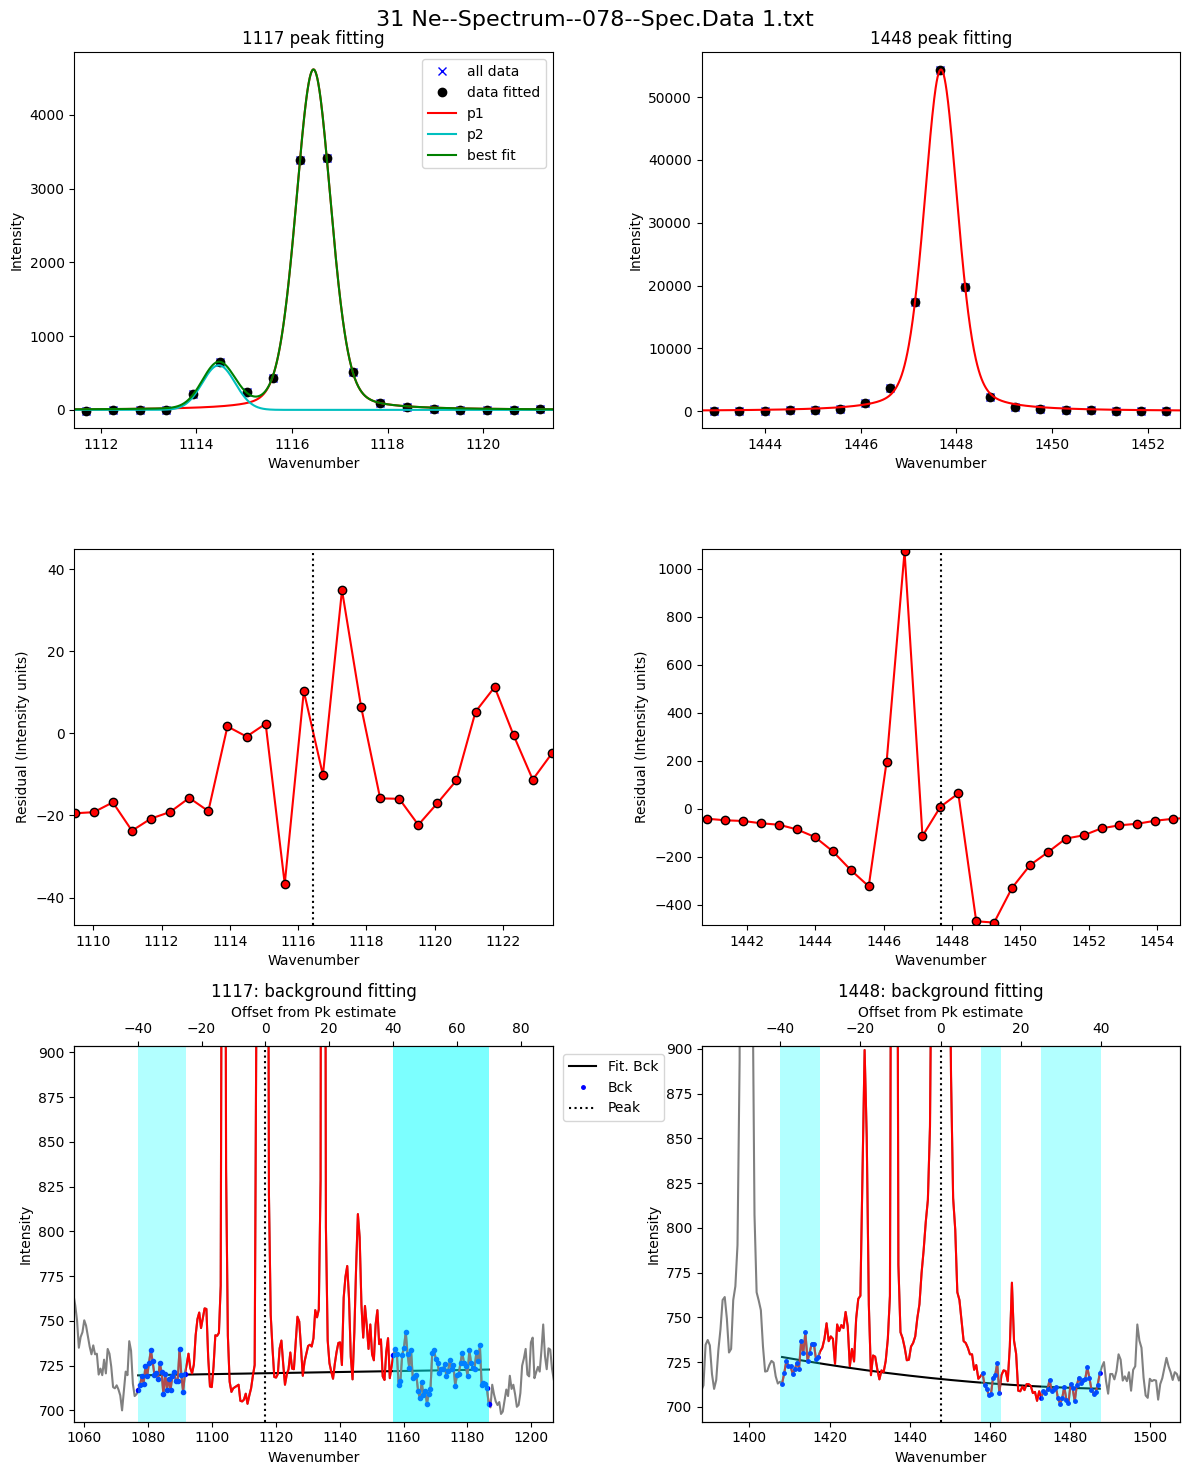

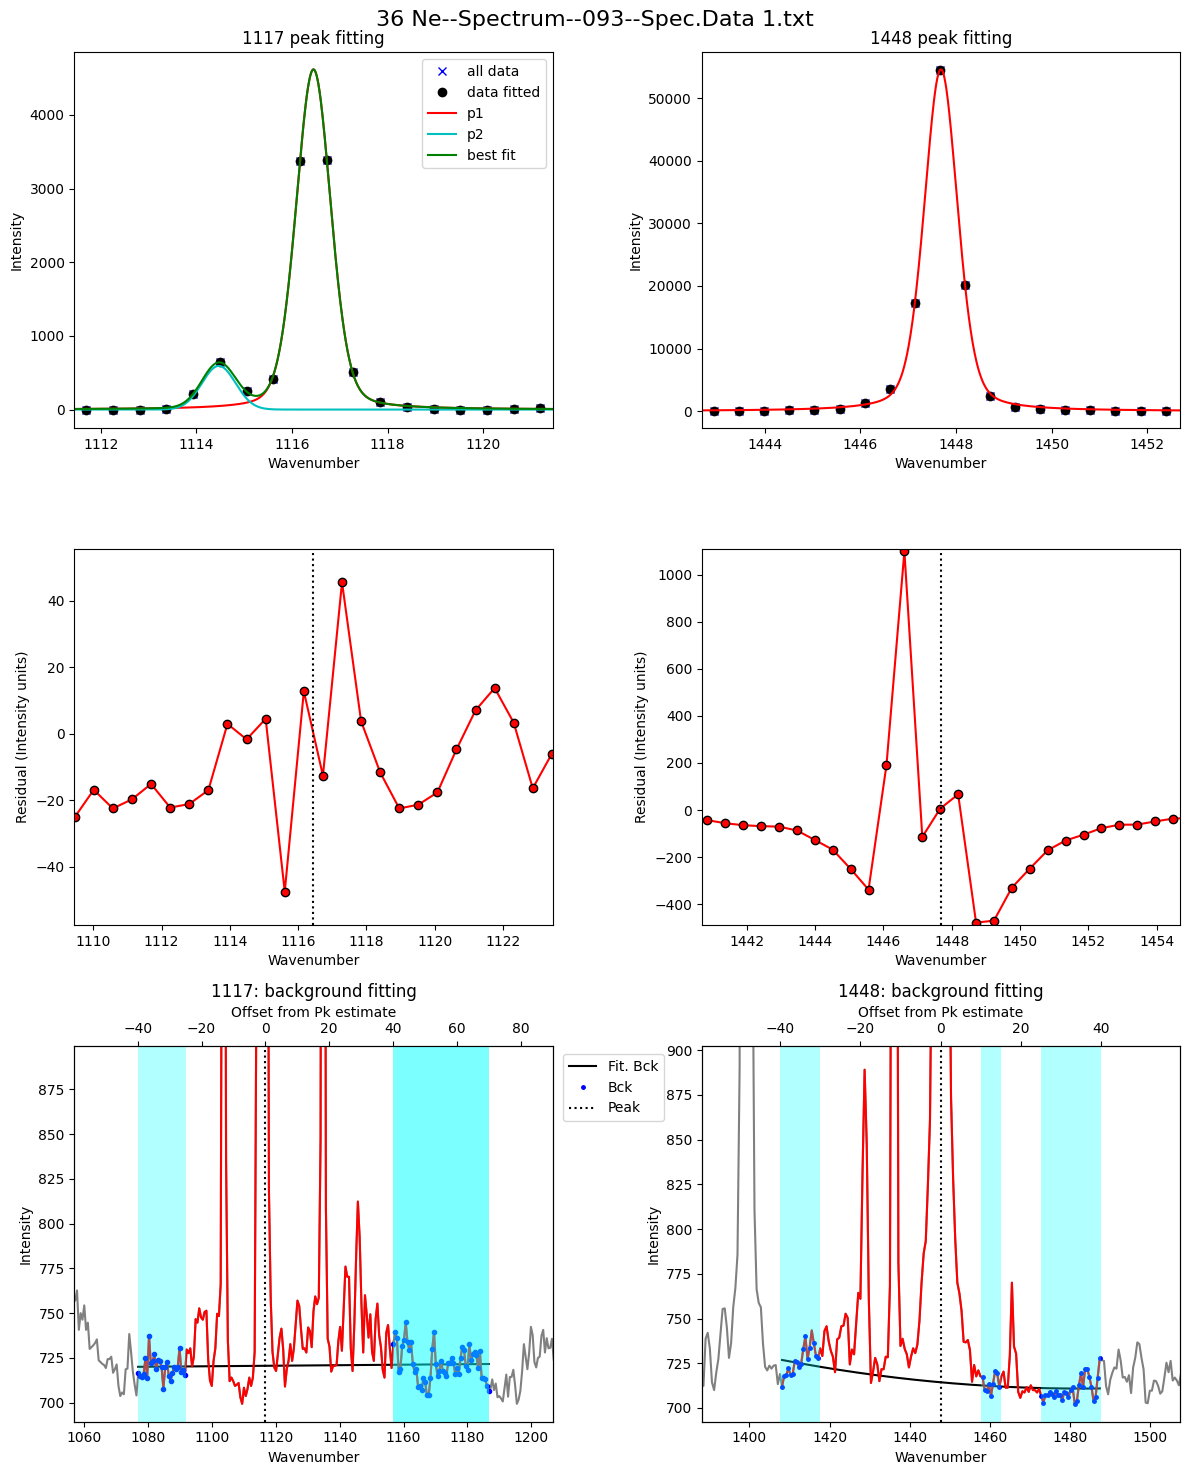

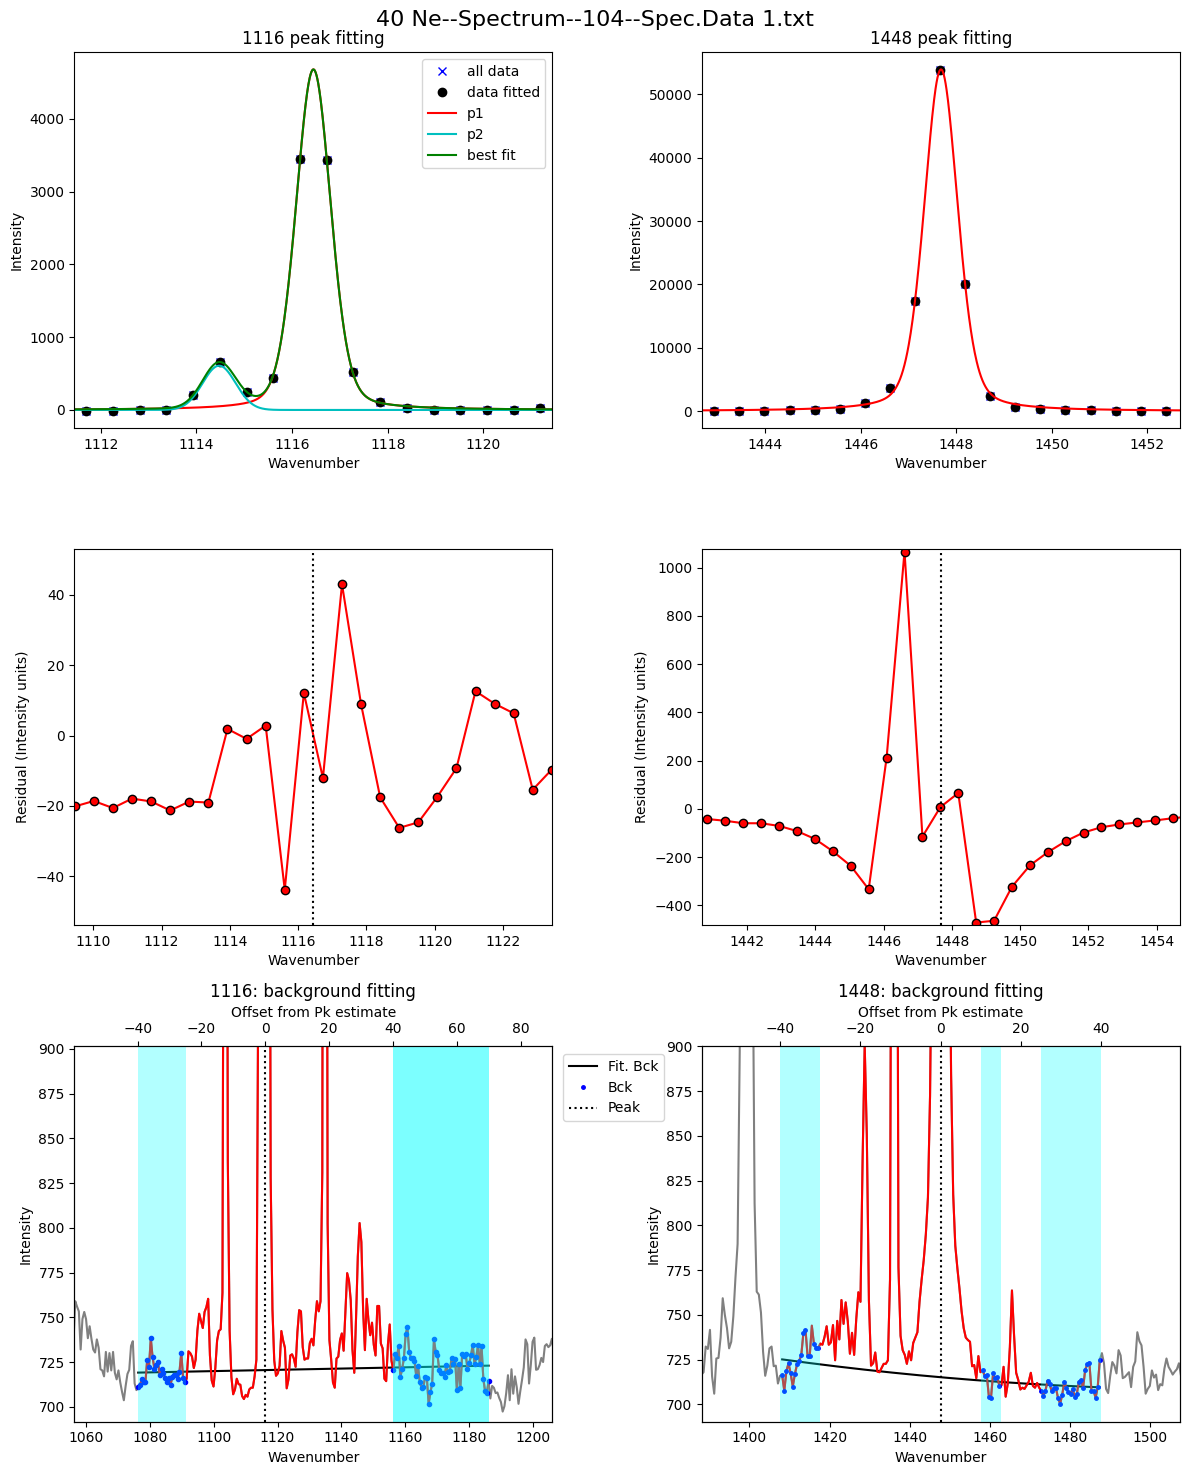

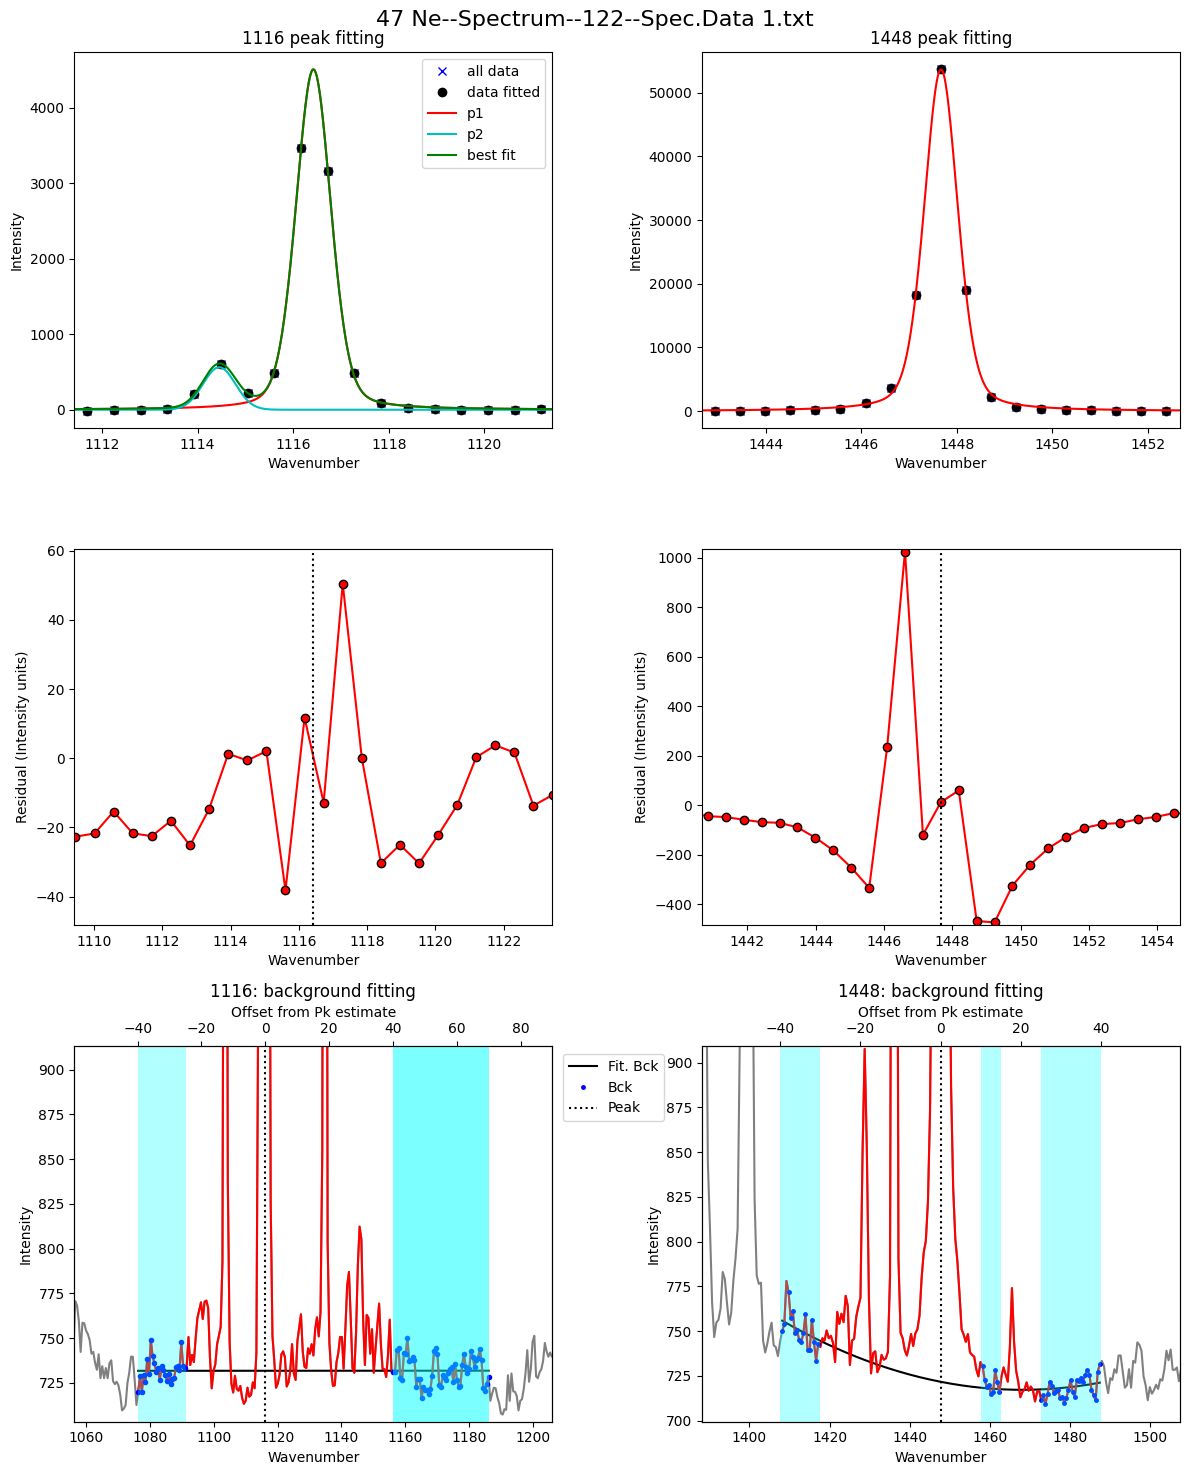

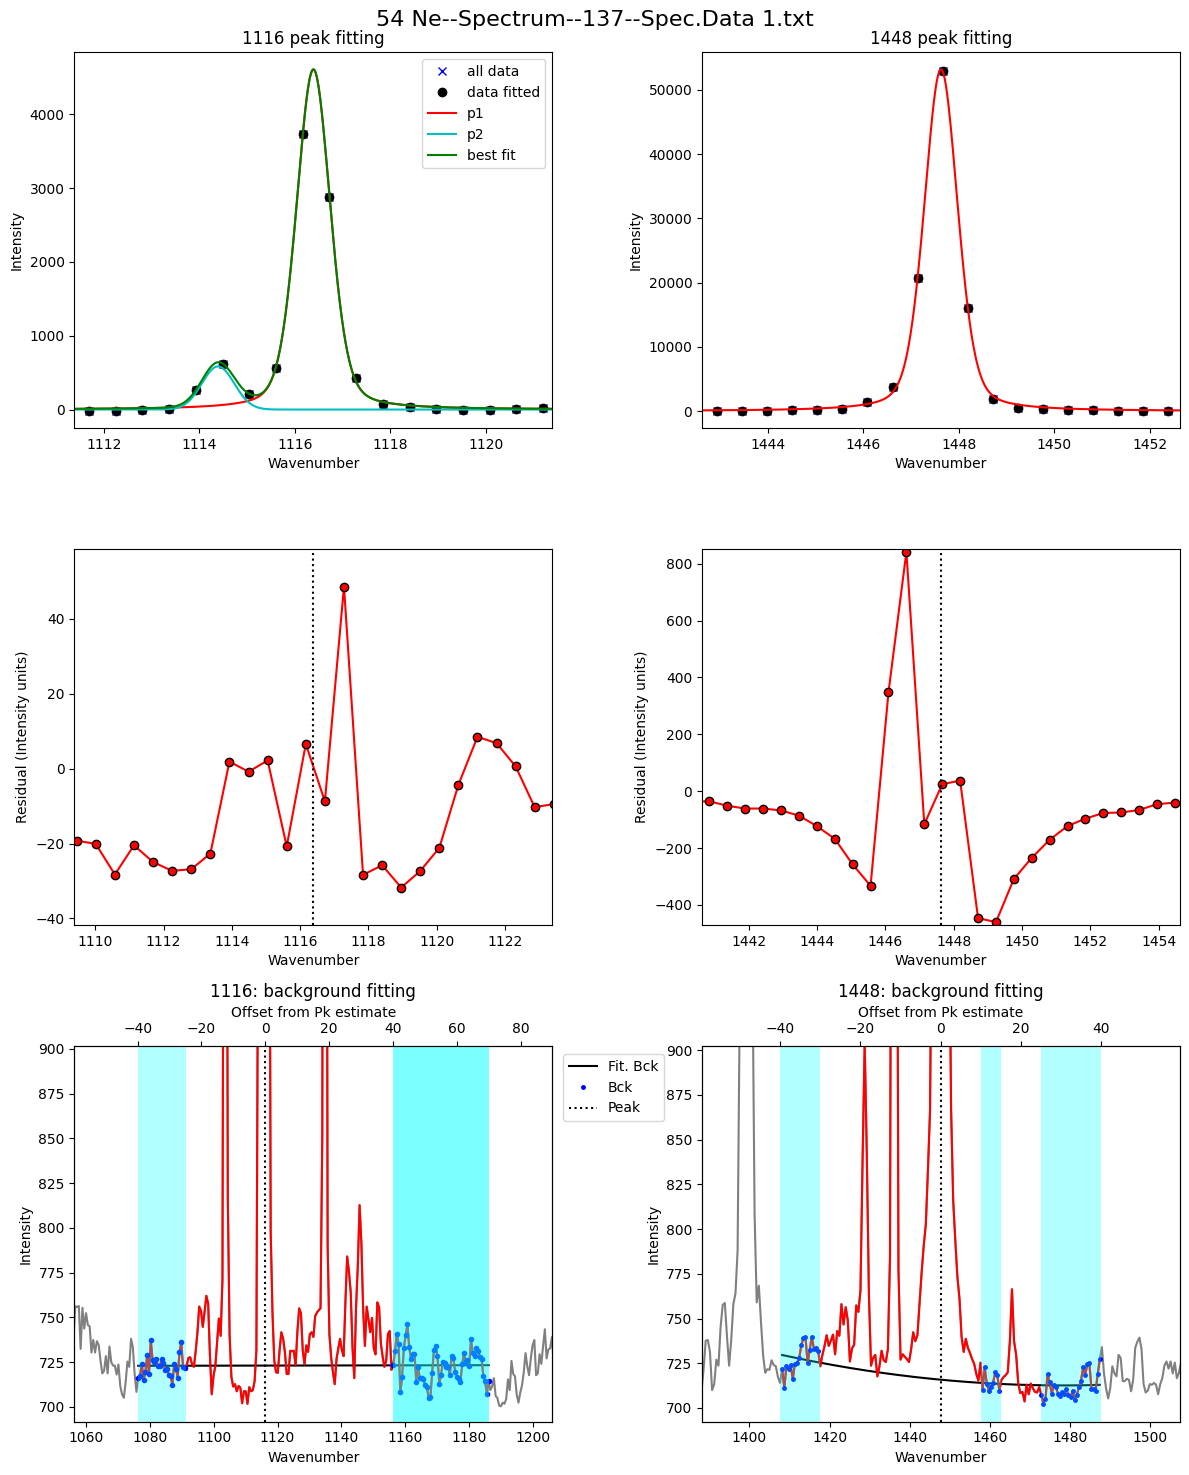

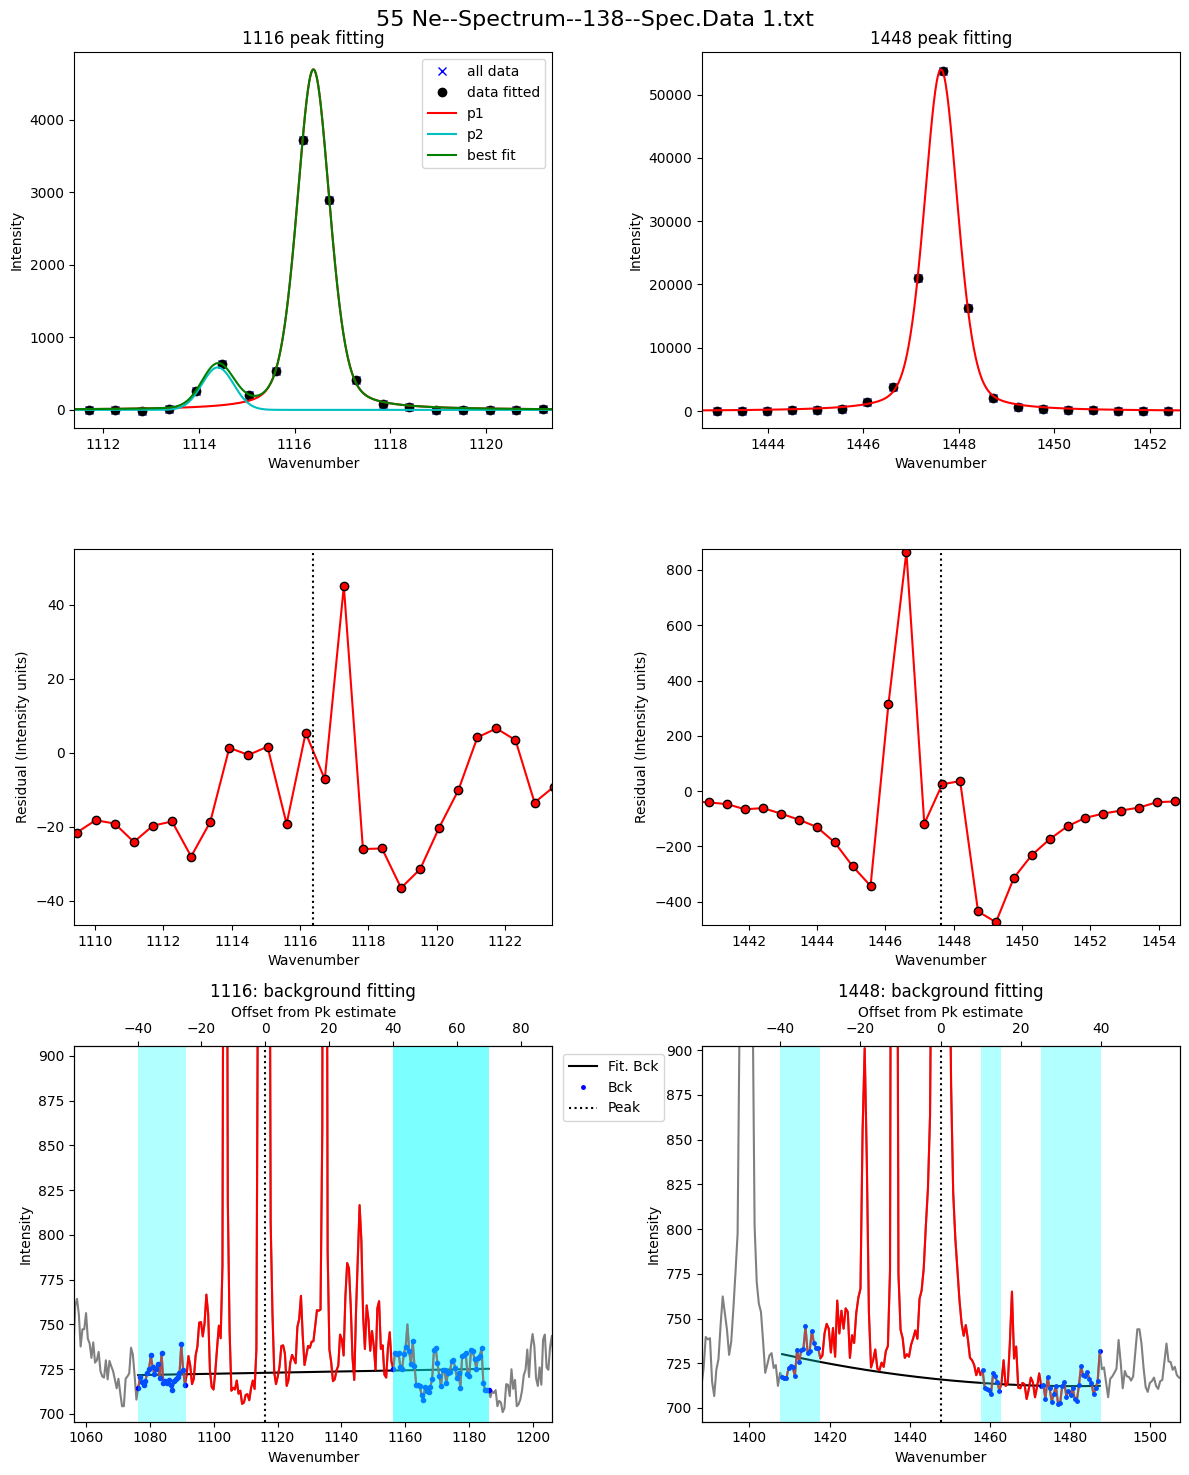

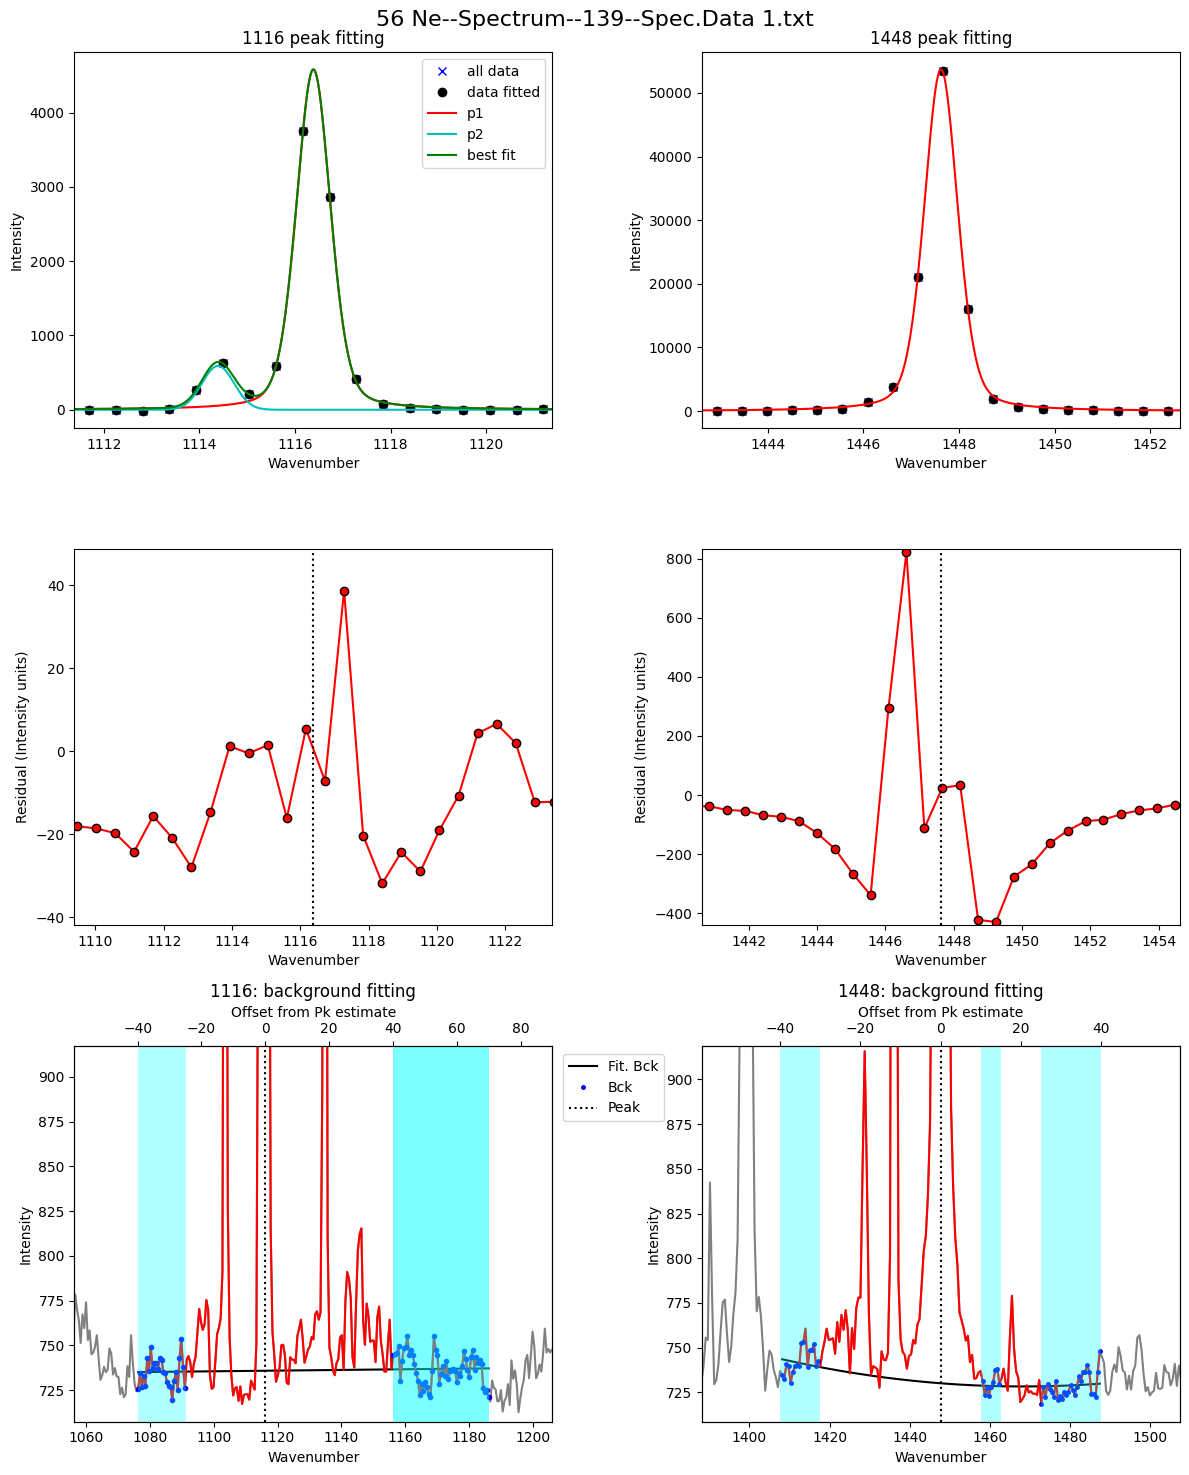

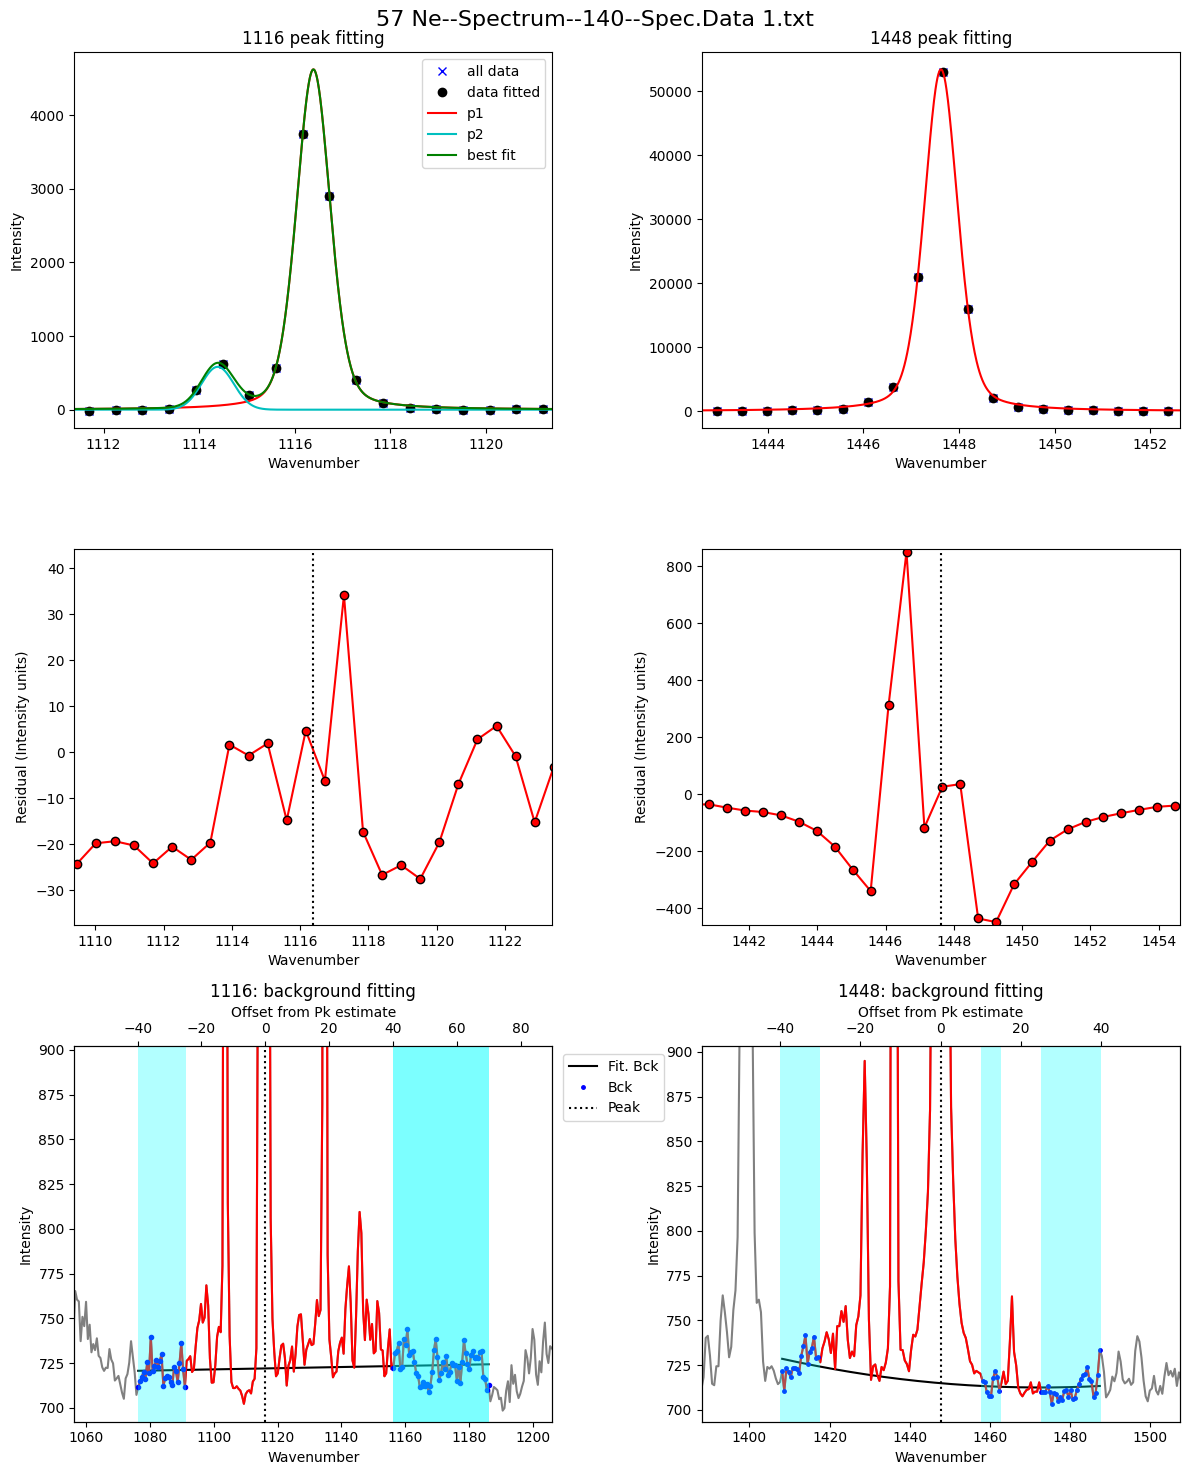

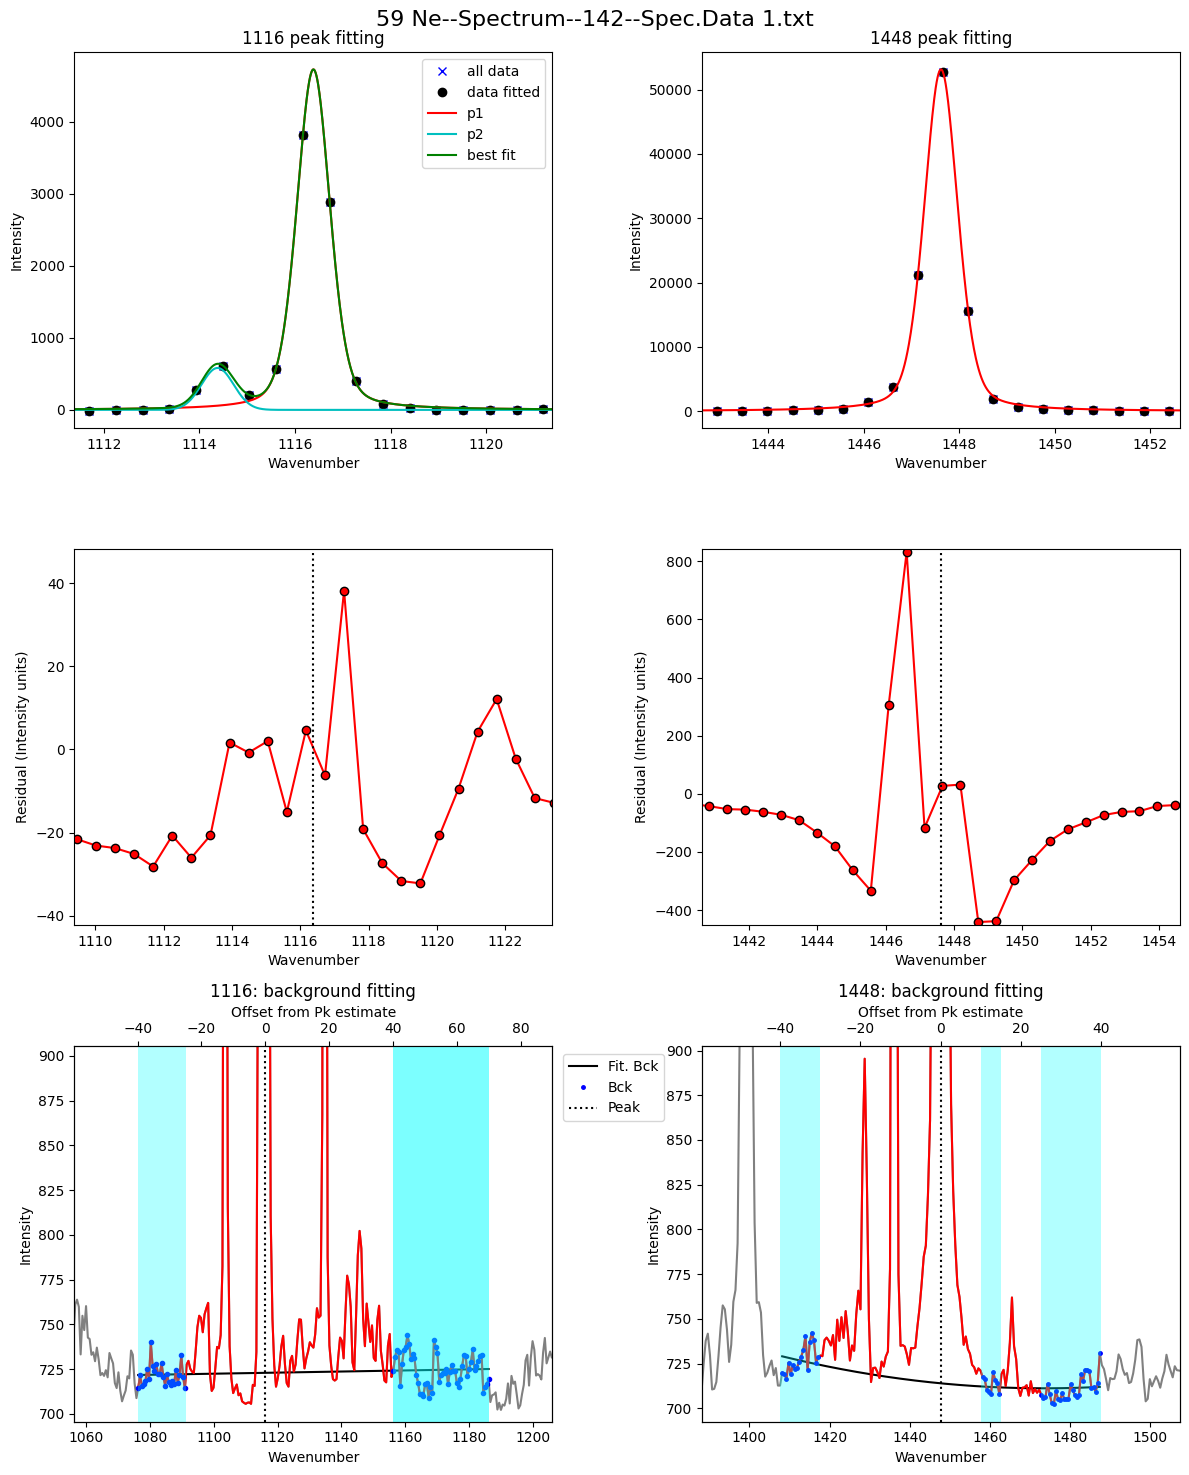

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--008--Spec.Data 1.txt  0.997856    0.000043  331.187814   
1   Ne--Spectrum--009--Spec.Data 1.txt  0.997854    0.000042  331.188450   
2   Ne--Spectrum--010--Spec.Data 1.txt  0.997845    0.000042  331.191402   
3   Ne--Spectrum--011--Spec.Data 1.txt  0.997844    0.000041  331.191533   
4   Ne--Spectrum--019--Spec.Data 1.txt  0.997817    0.000037  331.200577   
5   Ne--Spectrum--031--Spec.Data 1.txt  0.997794    0.000034  331.208284   
6   Ne--Spectrum--037--Spec.Data 1.txt  0.997763    0.000031  331.218479   
7   Ne--Spectrum--060--Spec.Data 1.txt  0.997744    0.000029  331.224938   
8   Ne--Spectrum--078--Spec.Data 1.txt  0.997727    0.000028  331.230641   
9   Ne--Spectrum--093--Spec.Data 1.txt  0.997711    0.000028  331.235900   
10  Ne--Spectrum--104--Spec.Data 1.txt  0.997711    0.000027  331.235705   
11  Ne--Spectrum--122--Spec.Data 1.txt  0.997691    0.000030  331.242517   
12  Ne--Spectrum--137--Spec.Data 1.txt  0.997703    0.000036  331.238464   
13  Ne--Spectrum--138--Spec.Data 1.txt  0.997715    0.000037  331.234626   
14  Ne--Spectrum--139--Spec.Data 1.txt  0.997698    0.000036  331.240196   
15  Ne--Spectrum--140--Spec.Data 1.txt  0.997714    0.000036  331.234759   
16  Ne--Spectrum--142--Spec.Data 1.txt  0.997716    0.000037  331.234100   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.475290    1116.287476   50056.561236    4411.267000    116.215633   
1     1447.500385    1116.311935   51024.679669    4532.674207    122.911330   
2     1447.507050    1116.315648   51077.613230    4629.431740    120.669456   
3     1447.528016    1116.336484   51071.633769    4661.888638    121.970331   
4     1447.588457    1116.387880   54388.058931    4595.181596    132.786920   
5     1447.610092    1116.401809   54730.776456    4689.273683    134.902962   
6     1447.636560    1116.418081   54286.760416    4603.188205    134.205151   
7     1447.661317    1116.436379   52917.875804    4532.054263    131.424617   
8     1447.678996    1116.448355   54620.050035    4688.958808    134.022136   
9     1447.683801    1116.447901   54852.499351    4662.328290    135.635489   
10    1447.681826    1116.446121   54475.383100    4756.944991    134.187349   
11    1447.667353    1116.424836   54304.299240    4608.396932    133.227835   
12    1447.627133    1116.388669   53696.285786    4656.953774    130.517737   
13    1447.626953    1116.392327   54468.813815    4668.994722    132.066303   
14    1447.625378    1116.385182   54135.832075    4654.022557    125.886983   
15    1447.623847    1116.389088   53958.307186    4662.244304    130.667557   
16    1447.619639    1116.385538   53647.804817    4722.278451    127.297066   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      12.471012  ...        0.403089   0.412958      None   0.014111   
1      11.941820  ...        0.408621   0.410465      None   0.013916   
2      13.657770  ...        0.406716   0.408224      None   0.013855   
3      12.539780  ...        0.408282   0.412735      None   0.013299   
4      14.694574  ...        0.405210   0.407783      None   0.012189   
5      15.639941  ...        0.401681   0.407471      None   0.011261   
6      13.461940  ...        0.401722   0.414036      None   0.010084   
7      14.232753  ...        0.400241   0.427715      None   0.009307   
8      13.417652  ...        0.394396   0.431038      None   0.009077   
9      15.153759  ...        0.393873   0.426854      None   0.008933   
10     15.354460  ...        0.391284   0.428773      None   0.008758   
11     15.495946  ...        0.397443   0.430308      None   0.009611   
12     16.992790  ...        0.395332   0.416448      None   0.011761   
13     15.767142  ...        0.401385   0.405286      None   0.012167   
14     15.152297  ...        0.395366   0.420843      None   0.011918   
15     14.403728  ...        0.403122   0.417195    

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['009 Ne--Spectrum--008--Information.txt',
 '010 Ne--Spectrum--009--Information.txt',
 '011 Ne--Spectrum--010--Information.txt',
 '012 Ne--Spectrum--011--Information.txt',
 '020 Ne--Spectrum--019--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 17/17 [00:00<00:00, 158.36it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--008--Information.txt  January 17, 2024\n  January  17.0   
1  Ne--Spectrum--009--Information.txt  January 17, 2024\n  January  17.0   
2  Ne--Spectrum--010--Information.txt  January 17, 2024\n  January  17.0   
3  Ne--Spectrum--011--Information.txt  January 17, 2024\n  January  17.0   
4  Ne--Spectrum--019--Information.txt  January 17, 2024\n  January  17.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       6.041          45.0            3.0    100.0  ['0h', '2m', '19s']   
1       5.949          45.0            3.0    100.0  ['0h', '2m', '16s']   
2       5.963          45.0            3.0    100.0  ['0h', '2m', '16s']   
3       6.078          45.0            3.0    100.0  ['0h', '2m', '16s']   
4       6.025          45.0            3.0    100.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  11:17:59 AM\n             40679.0         1325.004  
1  11:28:42 AM\n             41322.0         1325.004  
2  11:31:49 AM\n             41509.0         1325.004  
3  11:44:44 AM\n             42284.0         1325.004  
4  12:28:41 PM\n             44921.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

good job, no duplicate file names


array(['Ne--Spectrum--008', 'Ne--Spectrum--009', 'Ne--Spectrum--010',
       'Ne--Spectrum--011', 'Ne--Spectrum--019',
       'Ne--Spectrum--031--Spec.Data', 'Ne--Spectrum--037',
       'Ne--Spectrum--060', 'Ne--Spectrum--078', 'Ne--Spectrum--093',
       'Ne--Spectrum--104', 'Ne--Spectrum--122', 'Ne--Spectrum--137',
       'Ne--Spectrum--138', 'Ne--Spectrum--139', 'Ne--Spectrum--140',
       'Ne--Spectrum--142'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--008', 'Ne--Spectrum--009', 'Ne--Spectrum--010',
       'Ne--Spectrum--011', 'Ne--Spectrum--019', 'Ne--Spectrum--031',
       'Ne--Spectrum--037', 'Ne--Spectrum--060', 'Ne--Spectrum--078',
       'Ne--Spectrum--093', 'Ne--Spectrum--104', 'Ne--Spectrum--122',
       'Ne--Spectrum--137', 'Ne--Spectrum--138', 'Ne--Spectrum--139',
       'Ne--Spectrum--140', 'Ne--Spectrum--142'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 16, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     216.101649
1     208.346361
2     208.718085
3     206.302464
4     211.058548
5     213.719232
6     207.315345
7     217.022260
8     214.322724
9     218.620538
10    212.952221
11    218.870653
12    216.190417
13    220.916587
14    217.107870
15    215.502806
Name: error_pk2, dtype: float64

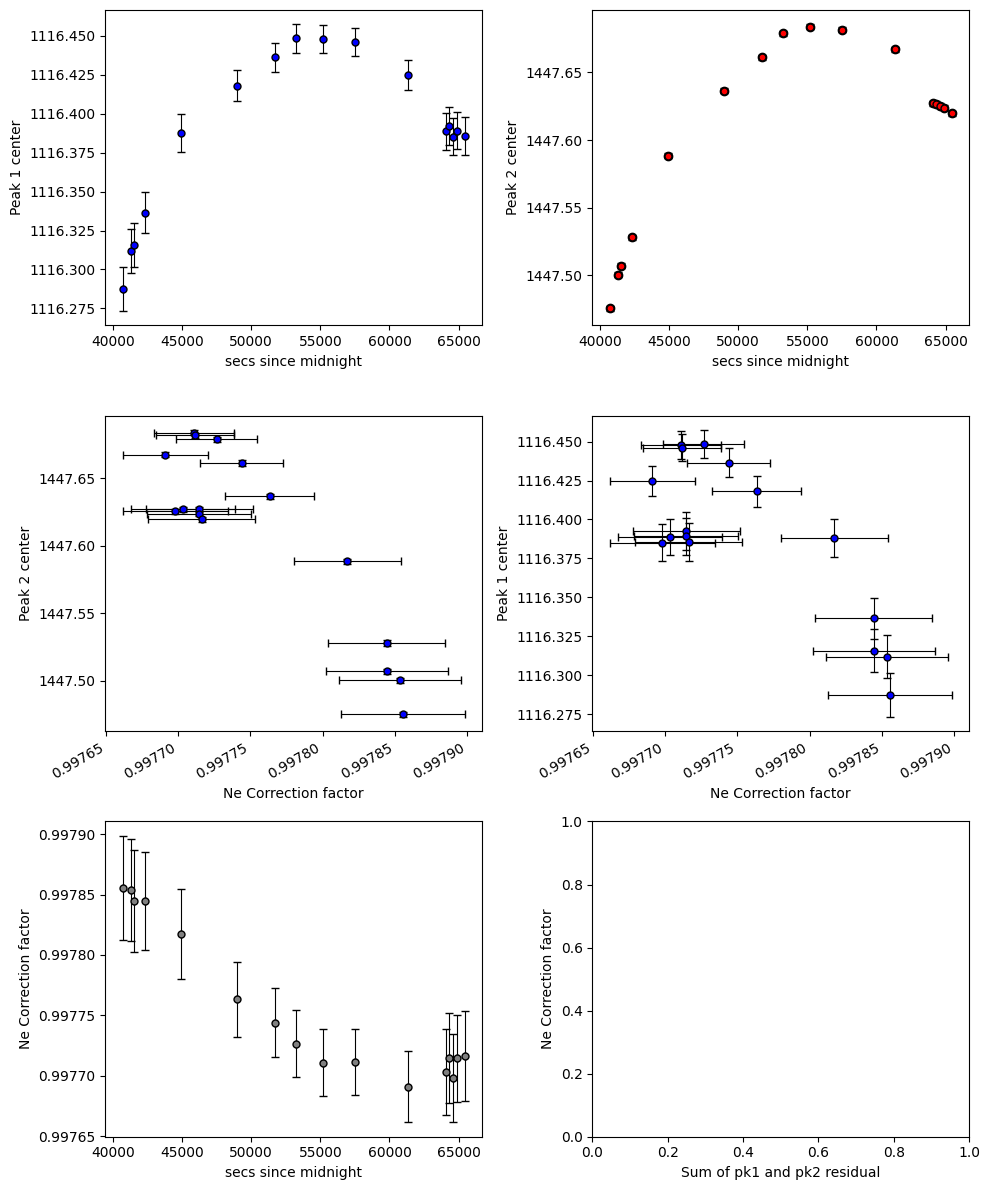

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

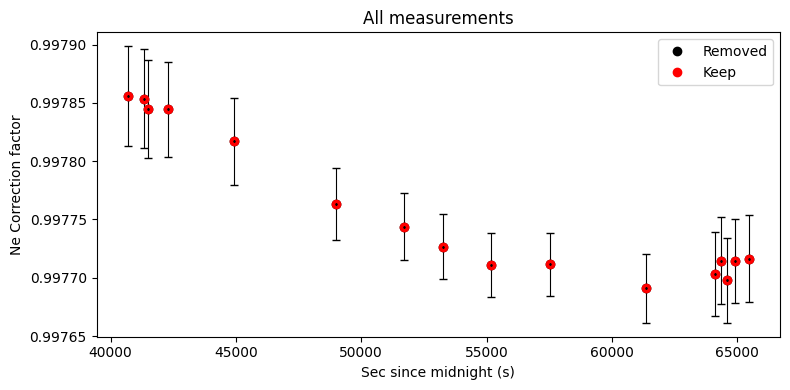

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

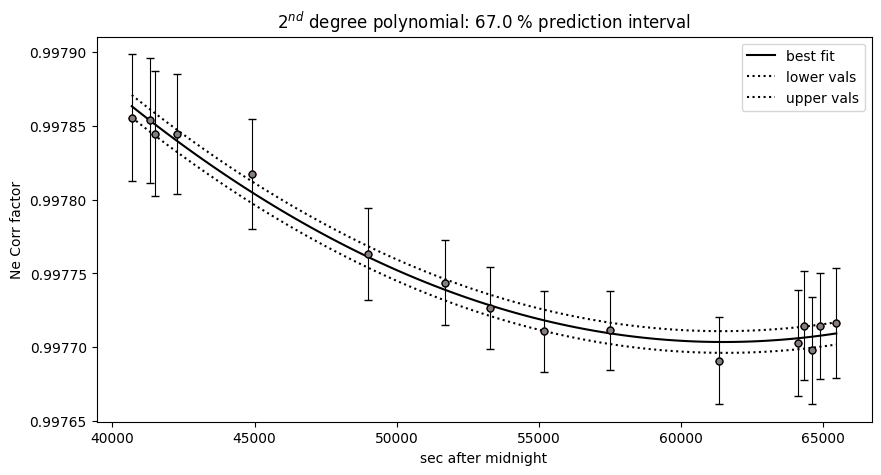

In [25]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
